# Neural network tuned with BOHB

## Importing

In [22]:
%cd ..
import hpbandster.core.nameserver as hpns
import hpbandster.core.result as hpres
from hpbandster.optimizers import BOHB
import hpbandster.visualization as hpvis
import logging
import pickle
logging.getLogger('hpbandster').setLevel(logging.DEBUG)
import matplotlib.pyplot as plt
import sys
sys.path.append("../")
from torch.utils.data import TensorDataset, DataLoader
import torch
import torch.nn as nn
import numpy as np
from torch.autograd import Variable
from torch.optim.lr_scheduler import ExponentialLR
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

from sklearn.metrics import mean_squared_error

from api import Benchmark
from func.taskA_NN_HPO import PyTorchWorker
logging.getLogger('matplotlib.font_manager').disabled = True

/Users/dilpreet/Desktop


## Load + Prepare data

In [2]:
bench_dir = "/Users/dilpreet/Desktop/deepl/Project/lc_bench/LCBench/fashion_mnist.json"
bench = Benchmark(bench_dir, cache=False)

import os as os
print(os.listdir("/Users/dilpreet/Desktop/deepl/Project/lc_bench/LCBench"))

print(os.path.isfile(bench_dir))

==> Loading data...
==> No cached data found or cache set to False.
==> Reading json data...
==> Done.
['fashion_mnist.json', '.DS_Store', 'lstm_bohb_LC_result_02.pkl', 'LICENSE', 'requirements.txt', 'lstm_bohb_LC_result_01.pkl', 'lstm_bohb_LC_result.pkl', 'cached', '__pycache__', 'sample_data_1.txt', 'losses_over_time.pdf', 'README.md', 'api.py', 'networks', '.gitignore', 'performance_histogram_model_vs_random.pdf', 'correlation_across_budgets.pdf', '.ipynb_checkpoints', '.git', 'notebooks', 'finished_runs_over_time.pdf', 'bohb_LC_result.pkl', 'func']
True


In [3]:
# Read data
def cut_data(data, cut_position):
    targets = []
    for dp in data:
        targets.append(dp["Train/val_accuracy"][50])
        for tag in dp:
            if tag.startswith("Train/"):
                dp[tag] = dp[tag][0:cut_position]
    return data, targets

def read_data():
    dataset_name = 'Fashion-MNIST'
    n_configs = bench.get_number_of_configs(dataset_name)
    
    # Query API
    data = []
    for config_id in range(n_configs):
        data_point = dict()
        data_point["config"] = bench.query(dataset_name=dataset_name, tag="config", config_id=config_id)
        for tag in bench.get_queriable_tags(dataset_name=dataset_name, config_id=config_id):
            if tag.startswith("Train/"):
                data_point[tag] = bench.query(dataset_name=dataset_name, tag=tag, config_id=config_id)    
        data.append(data_point)
        
    # Split: 50% train, 25% validation, 25% test (the data is already shuffled)
    indices = np.arange(n_configs)
    ind_train = indices[0:int(np.floor(0.5*n_configs))]
    ind_val = indices[int(np.floor(0.5*n_configs)):int(np.floor(0.75*n_configs))]
    ind_test = indices[int(np.floor(0.75*n_configs)):]

    array_data = np.array(data)
    train_data = array_data[ind_train]
    val_data = array_data[ind_val]
    test_data = array_data[ind_test]
    
    # Cut curves for validation and test
    cut_position = 11
    val_data, val_targets = cut_data(val_data, cut_position)
    test_data, test_targets = cut_data(test_data, cut_position)
    train_data, train_targets = cut_data(train_data, 51)   # Cut last value as it is repeated
    
    return train_data, val_data, test_data, train_targets, val_targets, test_targets
    
train_data, val_data, test_data, train_targets, val_targets, test_targets = read_data()

## Extract data features

In [5]:
def get_specific_inputs(input_data):
    N = len(input_data)
    config_features = np.zeros((N, 7))
    val_accuracy_till_ten_epoch = np.zeros((N, 10))

    for i in range(N):
        config_features[i][0] = input_data[i]["config"]["batch_size"]
        config_features[i][1] = input_data[i]["config"]["max_dropout"]
        config_features[i][2] = input_data[i]["config"]["max_units"]
        config_features[i][3] = input_data[i]["config"]["num_layers"]
        config_features[i][4] = input_data[i]["config"]["learning_rate"]
        config_features[i][5] = input_data[i]["config"]["momentum"]
        config_features[i][6] = input_data[i]["config"]["weight_decay"]
        val_accuracy_till_ten_epoch[i] = input_data[i]["Train/val_accuracy"][:10]
        
    #scale data
    #config_features = scale_features(config_features, method="minmax",direction="v")
    #val_accuracy_till_ten_epoch = scale_features(val_accuracy_till_ten_epoch, method="minmax")

    return(np.concatenate((config_features, val_accuracy_till_ten_epoch), axis=1))

In [6]:
tr_data= get_specific_inputs(train_data)
tr_labels= np.c_[train_targets]

vl_data= get_specific_inputs(val_data)
vl_labels= np.c_[val_targets]

tst_data = get_specific_inputs(test_data)
tst_labels= np.c_[test_targets]


(1000, 17)
[7.10000000e+01 2.59262318e-02 2.93000000e+02 3.00000000e+00
 1.82433003e-03 2.13251932e-01 2.04728169e-02 1.08088903e+01
 6.22044182e+01 6.95955582e+01 7.33880310e+01 7.47641830e+01
 7.59335861e+01 7.68510132e+01 7.76779938e+01 7.85372772e+01
 7.91639709e+01]
(1000, 1)
(500, 17)
[3.75000000e+02 7.68870677e-01 5.61000000e+02 2.00000000e+00
 1.22143489e-04 8.37406575e-01 9.44846457e-02 1.65977516e+01
 5.03941078e+01 5.95878029e+01 6.24693108e+01 6.42654114e+01
 6.54283524e+01 6.62811737e+01 6.71210785e+01 6.78188400e+01
 6.83615417e+01]


## Unsqueeze Data for cnn

In [7]:


BATCH_SIZE = 1

train_data = TensorDataset(torch.from_numpy(tr_data).float().unsqueeze(1), torch.from_numpy(tr_labels).float())
val_data = TensorDataset(torch.from_numpy(vl_data).float().unsqueeze(1), torch.from_numpy(vl_labels).float())
test_data = TensorDataset(torch.from_numpy(tst_data).float().unsqueeze(1), torch.from_numpy(tst_labels).float())

train_loader = DataLoader(train_data, shuffle=True, batch_size=BATCH_SIZE)
val_loader = DataLoader(val_data, shuffle=True, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_data, shuffle=True, batch_size=BATCH_SIZE)

In [7]:
# reshape data for lstm
# lstm_input = x.reshape(INPUT_SIZE,BATCH_SIZE, SEQ_LEN)
SEQ_LEN = 1
BATCH_SIZE = 1

train_data = TensorDataset(torch.from_numpy(tr_data).float(), torch.from_numpy(tr_labels).float())
val_data = TensorDataset(torch.from_numpy(vl_data).float(), torch.from_numpy(vl_labels).float())
test_data = TensorDataset(torch.from_numpy(tst_data).float(), torch.from_numpy(tst_labels).float())

train_loader = DataLoader(train_data, shuffle=True, batch_size=BATCH_SIZE)
val_loader = DataLoader(val_data, shuffle=True, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_data, shuffle=True, batch_size=BATCH_SIZE)

## Sanity test for out worker

In [8]:
working_dir = os.curdir
# minimum budget that BOHB uses
min_budget = 1
# largest budget BOHB will use
max_budget = 10

# model_type : 0 -> LSTM | 1-> CNN
worker = PyTorchWorker(run_id='0', train_loader= train_loader, validation_loader= val_loader, test_loader= test_loader)
configspace = worker.get_configspace()
worker.config = configspace
singleconfig = configspace.sample_configuration().get_dictionary()
print("Config: ", singleconfig)

Config:  {'lr': 0.05827619367732104, 'num_hidden_neurons': 93, 'num_lstm_layers': 1, 'optimizer': 'Adam'}


In [9]:
res = worker.compute(config=singleconfig, budget=min_budget, working_directory=working_dir)
print(res)

standard_LSTM(
  (lstm): LSTM(1, 93)
  (fc1): Linear(in_features=1581, out_features=1, bias=True)
)
{'loss': 61.38941692631831, 'info': {'test accuracy': 63.61064891365415, 'train accuracy': 74.19818080638093, 'validation accuracy': 61.38941692631831, 'model': 'standard_LSTM(\n  (lstm): LSTM(1, 93)\n  (fc1): Linear(in_features=1581, out_features=1, bias=True)\n)'}}


## BOHB parameters and variables

In [10]:
result_file = os.path.join(working_dir, 'lstm_bohb_LC_result_02.pkl')
nic_name = 'lo0'
port = 0
run_id = 'bohb_run_1'
n_bohb_iterations = 15

In [11]:
try:
    try:
        host = hpns.nic_name_to_host(nic_name)
    except ValueError as e:
        host = "localhost"
        print(e)
        print("ValueError getting host from nic_name {}, "
              "setting to localhost.".format(nic_name))    
    
    ns = hpns.NameServer(run_id=run_id, host=host, port=port,
                         working_directory=working_dir)
    ns_host, ns_port = ns.start()

    # Start local worker
    w = PyTorchWorker(run_id=run_id, host=host, nameserver=ns_host,
                      nameserver_port=ns_port, timeout=120, train_loader= train_loader, validation_loader= val_loader, test_loader= test_loader)
    w.run(background=True)

    # Run an optimizer
    bohb = BOHB(configspace=worker.get_configspace(),
                run_id=run_id,
                host=host,
                nameserver=ns_host,
                nameserver_port=ns_port,
                min_budget=min_budget, max_budget=max_budget)

    result = bohb.run(n_iterations=n_bohb_iterations)
    print("Write result to file {}".format(result_file))
    with open(result_file, 'wb') as f:
        pickle.dump(result, f)
finally:
    bohb.shutdown(shutdown_workers=True)
    ns.shutdown()

15:14:36 wait_for_workers trying to get the condition
15:14:36 DISPATCHER: started the 'discover_worker' thread
15:14:36 WORKER: Connected to nameserver <Pyro4.core.Proxy at 0x13ba32550; connected IPv4; for PYRO:Pyro.NameServer@127.0.0.1:59600>
15:14:36 DISPATCHER: started the 'job_runner' thread
15:14:36 WORKER: No dispatcher found. Waiting for one to initiate contact.
15:14:36 WORKER: start listening for jobs
15:14:36 DISPATCHER: Pyro daemon running on 127.0.0.1:59602
15:14:36 DISPATCHER: Starting worker discovery
15:14:36 DISPATCHER: Found 1 potential workers, 0 currently in the pool.
15:14:36 DISPATCHER: discovered new worker, hpbandster.run_bohb_run_1.worker.sisyphus-2.local.901814484918720
15:14:36 HBMASTER: number of workers changed to 1
15:14:36 Enough workers to start this run!
15:14:36 DISPATCHER: jobs to submit = 0, number of idle workers = 1 -> waiting!
15:14:36 adjust_queue_size: lock accquired
15:14:36 HBMASTER: adjusted queue size to (0, 1)
15:14:36 HBMASTER: starting ru

standard_LSTM(
  (lstm): LSTM(1, 97, num_layers=2)
  (fc1): Linear(in_features=1649, out_features=1, bias=True)
)


15:14:48 WORKER: done with job (0, 0, 0), trying to register it.
15:14:48 WORKER: registered result for job (0, 0, 0) with dispatcher
15:14:48 DISPATCHER: job (0, 0, 0) finished
15:14:48 DISPATCHER: register_result: lock acquired
15:14:48 DISPATCHER: job (0, 0, 0) on hpbandster.run_bohb_run_1.worker.sisyphus-2.local.901814484918720 finished
15:14:48 job_id: (0, 0, 0)
kwargs: {'config': {'lr': 0.071328308228461, 'num_hidden_neurons': 97, 'num_lstm_layers': 2, 'optimizer': 'SGD', 'sgd_momentum': 0.4428500504414759}, 'budget': 1.1111111111111112, 'working_directory': '.'}
result: {'loss': nan, 'info': {'test accuracy': nan, 'train accuracy': nan, 'validation accuracy': nan, 'model': 'standard_LSTM(\n  (lstm): LSTM(1, 97, num_layers=2)\n  (fc1): Linear(in_features=1649, out_features=1, bias=True)\n)'}}
exception: None

15:14:48 job_callback for (0, 0, 0) started
15:14:48 DISPATCHER: Trying to submit another job.
15:14:48 job_callback for (0, 0, 0) got condition
15:14:48 DISPATCHER: jobs to

standard_LSTM(
  (lstm): LSTM(1, 95)
  (fc1): Linear(in_features=1615, out_features=1, bias=True)
)


15:14:54 WORKER: done with job (0, 0, 1), trying to register it.
15:14:54 WORKER: registered result for job (0, 0, 1) with dispatcher
15:14:54 DISPATCHER: job (0, 0, 1) finished
15:14:54 DISPATCHER: register_result: lock acquired
15:14:54 DISPATCHER: job (0, 0, 1) on hpbandster.run_bohb_run_1.worker.sisyphus-2.local.901814484918720 finished
15:14:54 job_id: (0, 0, 1)
kwargs: {'config': {'lr': 0.027390043837951236, 'num_hidden_neurons': 95, 'num_lstm_layers': 1, 'optimizer': 'SGD', 'sgd_momentum': 0.2642712256570271}, 'budget': 1.1111111111111112, 'working_directory': '.'}
result: {'loss': nan, 'info': {'test accuracy': nan, 'train accuracy': nan, 'validation accuracy': nan, 'model': 'standard_LSTM(\n  (lstm): LSTM(1, 95)\n  (fc1): Linear(in_features=1615, out_features=1, bias=True)\n)'}}
exception: None

15:14:54 job_callback for (0, 0, 1) started
15:14:54 DISPATCHER: Trying to submit another job.
15:14:54 job_callback for (0, 0, 1) got condition
15:14:54 DISPATCHER: jobs to submit = 0

standard_LSTM(
  (lstm): LSTM(1, 98, num_layers=2)
  (fc1): Linear(in_features=1666, out_features=1, bias=True)
)


15:15:06 WORKER: done with job (0, 0, 2), trying to register it.
15:15:06 WORKER: registered result for job (0, 0, 2) with dispatcher
15:15:06 DISPATCHER: job (0, 0, 2) finished
15:15:06 DISPATCHER: register_result: lock acquired
15:15:06 DISPATCHER: job (0, 0, 2) on hpbandster.run_bohb_run_1.worker.sisyphus-2.local.901814484918720 finished
15:15:06 job_id: (0, 0, 2)
kwargs: {'config': {'lr': 0.001554492109094481, 'num_hidden_neurons': 98, 'num_lstm_layers': 2, 'optimizer': 'Adam'}, 'budget': 1.1111111111111112, 'working_directory': '.'}
result: {'loss': 36.52745547882875, 'info': {'test accuracy': 34.020947860413926, 'train accuracy': 40.3012247939576, 'validation accuracy': 36.52745547882875, 'model': 'standard_LSTM(\n  (lstm): LSTM(1, 98, num_layers=2)\n  (fc1): Linear(in_features=1666, out_features=1, bias=True)\n)'}}
exception: None

15:15:06 job_callback for (0, 0, 2) started
15:15:06 DISPATCHER: Trying to submit another job.
15:15:06 DISPATCHER: jobs to submit = 0, number of idl

standard_LSTM(
  (lstm): LSTM(1, 97, num_layers=2)
  (fc1): Linear(in_features=1649, out_features=1, bias=True)
)


15:15:17 WORKER: done with job (0, 0, 3), trying to register it.
15:15:17 WORKER: registered result for job (0, 0, 3) with dispatcher
15:15:17 DISPATCHER: job (0, 0, 3) finished
15:15:17 DISPATCHER: register_result: lock acquired
15:15:17 DISPATCHER: job (0, 0, 3) on hpbandster.run_bohb_run_1.worker.sisyphus-2.local.901814484918720 finished
15:15:17 job_id: (0, 0, 3)
kwargs: {'config': {'lr': 1.2922920928505572e-06, 'num_hidden_neurons': 97, 'num_lstm_layers': 2, 'optimizer': 'SGD', 'sgd_momentum': 0.5228043851130324}, 'budget': 1.1111111111111112, 'working_directory': '.'}
result: {'loss': 253.09814436745643, 'info': {'test accuracy': 253.20047862309963, 'train accuracy': 263.03611875896064, 'validation accuracy': 253.09814436745643, 'model': 'standard_LSTM(\n  (lstm): LSTM(1, 97, num_layers=2)\n  (fc1): Linear(in_features=1649, out_features=1, bias=True)\n)'}}
exception: None

15:15:17 job_callback for (0, 0, 3) started
15:15:17 job_callback for (0, 0, 3) got condition
15:15:17 DISPA

standard_LSTM(
  (lstm): LSTM(1, 106)
  (fc1): Linear(in_features=1802, out_features=1, bias=True)
)


15:15:25 WORKER: done with job (0, 0, 4), trying to register it.
15:15:25 WORKER: registered result for job (0, 0, 4) with dispatcher
15:15:25 DISPATCHER: job (0, 0, 4) finished
15:15:25 DISPATCHER: register_result: lock acquired
15:15:25 DISPATCHER: job (0, 0, 4) on hpbandster.run_bohb_run_1.worker.sisyphus-2.local.901814484918720 finished
15:15:25 job_id: (0, 0, 4)
kwargs: {'config': {'lr': 0.006083869818146126, 'num_hidden_neurons': 106, 'num_lstm_layers': 1, 'optimizer': 'SGD', 'sgd_momentum': 0.9245685216524019}, 'budget': 1.1111111111111112, 'working_directory': '.'}
result: {'loss': 242.9760419756733, 'info': {'test accuracy': 238.82947508590343, 'train accuracy': 251.15965342524962, 'validation accuracy': 242.9760419756733, 'model': 'standard_LSTM(\n  (lstm): LSTM(1, 106)\n  (fc1): Linear(in_features=1802, out_features=1, bias=True)\n)'}}
exception: None

15:15:25 job_callback for (0, 0, 4) started
15:15:25 job_callback for (0, 0, 4) got condition
15:15:25 DISPATCHER: Trying to

standard_LSTM(
  (lstm): LSTM(1, 93)
  (fc1): Linear(in_features=1581, out_features=1, bias=True)
)


15:15:31 WORKER: done with job (0, 0, 5), trying to register it.
15:15:31 WORKER: registered result for job (0, 0, 5) with dispatcher
15:15:31 DISPATCHER: job (0, 0, 5) finished
15:15:31 DISPATCHER: register_result: lock acquired
15:15:31 DISPATCHER: job (0, 0, 5) on hpbandster.run_bohb_run_1.worker.sisyphus-2.local.901814484918720 finished
15:15:31 job_id: (0, 0, 5)
kwargs: {'config': {'lr': 0.004595336683140466, 'num_hidden_neurons': 93, 'num_lstm_layers': 1, 'optimizer': 'Adam'}, 'budget': 1.1111111111111112, 'working_directory': '.'}
result: {'loss': 12.709281684262562, 'info': {'test accuracy': 11.26656874385476, 'train accuracy': 13.846955652294099, 'validation accuracy': 12.709281684262562, 'model': 'standard_LSTM(\n  (lstm): LSTM(1, 93)\n  (fc1): Linear(in_features=1581, out_features=1, bias=True)\n)'}}
exception: None

15:15:31 job_callback for (0, 0, 5) started
15:15:31 job_callback for (0, 0, 5) got condition
15:15:31 DISPATCHER: Trying to submit another job.
15:15:31 HBMAST

standard_LSTM(
  (lstm): LSTM(1, 107, num_layers=2)
  (fc1): Linear(in_features=1819, out_features=1, bias=True)
)


15:15:36 DISPATCHER: Starting worker discovery
15:15:36 DISPATCHER: Found 1 potential workers, 1 currently in the pool.
15:15:36 DISPATCHER: Finished worker discovery
15:15:43 WORKER: done with job (0, 0, 6), trying to register it.
15:15:43 WORKER: registered result for job (0, 0, 6) with dispatcher
15:15:43 DISPATCHER: job (0, 0, 6) finished
15:15:43 DISPATCHER: register_result: lock acquired
15:15:43 DISPATCHER: job (0, 0, 6) on hpbandster.run_bohb_run_1.worker.sisyphus-2.local.901814484918720 finished
15:15:43 job_id: (0, 0, 6)
kwargs: {'config': {'lr': 0.0014620343819714565, 'num_hidden_neurons': 107, 'num_lstm_layers': 2, 'optimizer': 'SGD', 'sgd_momentum': 0.7625923023086969}, 'budget': 1.1111111111111112, 'working_directory': '.'}
result: {'loss': 74.88249939785037, 'info': {'test accuracy': 76.03805930097587, 'train accuracy': 84.68879352838441, 'validation accuracy': 74.88249939785037, 'model': 'standard_LSTM(\n  (lstm): LSTM(1, 107, num_layers=2)\n  (fc1): Linear(in_features=

standard_LSTM(
  (lstm): LSTM(1, 90, num_layers=2)
  (fc1): Linear(in_features=1530, out_features=1, bias=True)
)


15:15:55 WORKER: done with job (0, 0, 7), trying to register it.
15:15:55 WORKER: registered result for job (0, 0, 7) with dispatcher
15:15:55 DISPATCHER: job (0, 0, 7) finished
15:15:55 DISPATCHER: register_result: lock acquired
15:15:55 DISPATCHER: job (0, 0, 7) on hpbandster.run_bohb_run_1.worker.sisyphus-2.local.901814484918720 finished
15:15:55 job_id: (0, 0, 7)
kwargs: {'config': {'lr': 0.003126296138432294, 'num_hidden_neurons': 90, 'num_lstm_layers': 2, 'optimizer': 'Adam'}, 'budget': 1.1111111111111112, 'working_directory': '.'}
result: {'loss': 60.14452963812754, 'info': {'test accuracy': 61.743295008437826, 'train accuracy': 72.64021162559314, 'validation accuracy': 60.14452963812754, 'model': 'standard_LSTM(\n  (lstm): LSTM(1, 90, num_layers=2)\n  (fc1): Linear(in_features=1530, out_features=1, bias=True)\n)'}}
exception: None

15:15:55 job_callback for (0, 0, 7) started
15:15:55 DISPATCHER: Trying to submit another job.
15:15:55 DISPATCHER: jobs to submit = 0, number of id

standard_LSTM(
  (lstm): LSTM(1, 103)
  (fc1): Linear(in_features=1751, out_features=1, bias=True)
)


15:16:02 WORKER: done with job (0, 0, 8), trying to register it.
15:16:02 WORKER: registered result for job (0, 0, 8) with dispatcher
15:16:02 DISPATCHER: job (0, 0, 8) finished
15:16:02 DISPATCHER: register_result: lock acquired
15:16:02 DISPATCHER: job (0, 0, 8) on hpbandster.run_bohb_run_1.worker.sisyphus-2.local.901814484918720 finished
15:16:02 job_id: (0, 0, 8)
kwargs: {'config': {'lr': 0.00042403231879899206, 'num_hidden_neurons': 103, 'num_lstm_layers': 1, 'optimizer': 'SGD', 'sgd_momentum': 0.5609621413866478}, 'budget': 1.1111111111111112, 'working_directory': '.'}
result: {'loss': 51.07841293987748, 'info': {'test accuracy': 51.85978060802049, 'train accuracy': 60.35662944169075, 'validation accuracy': 51.07841293987748, 'model': 'standard_LSTM(\n  (lstm): LSTM(1, 103)\n  (fc1): Linear(in_features=1751, out_features=1, bias=True)\n)'}}
exception: None

15:16:02 job_callback for (0, 0, 8) started
15:16:02 DISPATCHER: Trying to submit another job.
15:16:02 DISPATCHER: jobs to 

standard_LSTM(
  (lstm): LSTM(1, 98, num_layers=2)
  (fc1): Linear(in_features=1666, out_features=1, bias=True)
)


15:16:14 WORKER: done with job (0, 0, 2), trying to register it.
15:16:14 WORKER: registered result for job (0, 0, 2) with dispatcher
15:16:14 DISPATCHER: job (0, 0, 2) finished
15:16:14 DISPATCHER: register_result: lock acquired
15:16:14 DISPATCHER: job (0, 0, 2) on hpbandster.run_bohb_run_1.worker.sisyphus-2.local.901814484918720 finished
15:16:14 job_id: (0, 0, 2)
kwargs: {'config': {'lr': 0.001554492109094481, 'num_hidden_neurons': 98, 'num_lstm_layers': 2, 'optimizer': 'Adam'}, 'budget': 3.333333333333333, 'working_directory': '.'}
result: {'loss': 20.64792446278094, 'info': {'test accuracy': 18.588870045650168, 'train accuracy': 24.883788524237403, 'validation accuracy': 20.64792446278094, 'model': 'standard_LSTM(\n  (lstm): LSTM(1, 98, num_layers=2)\n  (fc1): Linear(in_features=1666, out_features=1, bias=True)\n)'}}
exception: None

15:16:14 job_callback for (0, 0, 2) started
15:16:14 job_callback for (0, 0, 2) got condition
15:16:14 Only 1 run(s) for budget 3.333333 available, 

standard_LSTM(
  (lstm): LSTM(1, 93)
  (fc1): Linear(in_features=1581, out_features=1, bias=True)
)


15:16:20 WORKER: done with job (0, 0, 5), trying to register it.
15:16:20 WORKER: registered result for job (0, 0, 5) with dispatcher
15:16:20 DISPATCHER: job (0, 0, 5) finished
15:16:20 DISPATCHER: register_result: lock acquired
15:16:20 DISPATCHER: job (0, 0, 5) on hpbandster.run_bohb_run_1.worker.sisyphus-2.local.901814484918720 finished
15:16:20 job_id: (0, 0, 5)
kwargs: {'config': {'lr': 0.004595336683140466, 'num_hidden_neurons': 93, 'num_lstm_layers': 1, 'optimizer': 'Adam'}, 'budget': 3.333333333333333, 'working_directory': '.'}
result: {'loss': 12.986285629838472, 'info': {'test accuracy': 11.600382891679416, 'train accuracy': 14.035258089613519, 'validation accuracy': 12.986285629838472, 'model': 'standard_LSTM(\n  (lstm): LSTM(1, 93)\n  (fc1): Linear(in_features=1581, out_features=1, bias=True)\n)'}}
exception: None

15:16:20 job_callback for (0, 0, 5) started
15:16:20 DISPATCHER: Trying to submit another job.
15:16:20 DISPATCHER: jobs to submit = 0, number of idle workers =

standard_LSTM(
  (lstm): LSTM(1, 103)
  (fc1): Linear(in_features=1751, out_features=1, bias=True)
)


15:16:27 WORKER: done with job (0, 0, 8), trying to register it.
15:16:27 WORKER: registered result for job (0, 0, 8) with dispatcher
15:16:27 DISPATCHER: job (0, 0, 8) finished
15:16:27 DISPATCHER: register_result: lock acquired
15:16:27 DISPATCHER: job (0, 0, 8) on hpbandster.run_bohb_run_1.worker.sisyphus-2.local.901814484918720 finished
15:16:27 job_id: (0, 0, 8)
kwargs: {'config': {'lr': 0.00042403231879899206, 'num_hidden_neurons': 103, 'num_lstm_layers': 1, 'optimizer': 'SGD', 'sgd_momentum': 0.5609621413866478}, 'budget': 3.333333333333333, 'working_directory': '.'}
result: {'loss': 64.80830007855641, 'info': {'test accuracy': 62.30641466497257, 'train accuracy': 73.3833315657936, 'validation accuracy': 64.80830007855641, 'model': 'standard_LSTM(\n  (lstm): LSTM(1, 103)\n  (fc1): Linear(in_features=1751, out_features=1, bias=True)\n)'}}
exception: None

15:16:27 job_callback for (0, 0, 8) started
15:16:27 job_callback for (0, 0, 8) got condition
15:16:27 DISPATCHER: Trying to s

standard_LSTM(
  (lstm): LSTM(1, 93)
  (fc1): Linear(in_features=1581, out_features=1, bias=True)
)


15:16:33 WORKER: done with job (0, 0, 5), trying to register it.
15:16:33 WORKER: registered result for job (0, 0, 5) with dispatcher
15:16:33 DISPATCHER: job (0, 0, 5) finished
15:16:33 DISPATCHER: register_result: lock acquired
15:16:33 DISPATCHER: job (0, 0, 5) on hpbandster.run_bohb_run_1.worker.sisyphus-2.local.901814484918720 finished
15:16:33 job_id: (0, 0, 5)
kwargs: {'config': {'lr': 0.004595336683140466, 'num_hidden_neurons': 93, 'num_lstm_layers': 1, 'optimizer': 'Adam'}, 'budget': 10.0, 'working_directory': '.'}
result: {'loss': 14.425937559394399, 'info': {'test accuracy': 12.611901207916555, 'train accuracy': 15.666710693844244, 'validation accuracy': 14.425937559394399, 'model': 'standard_LSTM(\n  (lstm): LSTM(1, 93)\n  (fc1): Linear(in_features=1581, out_features=1, bias=True)\n)'}}
exception: None

15:16:33 job_callback for (0, 0, 5) started
15:16:33 job_callback for (0, 0, 5) got condition
15:16:33 Only 1 run(s) for budget 10.000000 available, need more than 7 -> can'

standard_LSTM(
  (lstm): LSTM(1, 92, num_layers=2)
  (fc1): Linear(in_features=1564, out_features=1, bias=True)
)


15:16:36 DISPATCHER: Starting worker discovery
15:16:36 DISPATCHER: Found 1 potential workers, 1 currently in the pool.
15:16:36 DISPATCHER: Finished worker discovery
15:16:45 WORKER: done with job (1, 0, 0), trying to register it.
15:16:45 WORKER: registered result for job (1, 0, 0) with dispatcher
15:16:45 DISPATCHER: job (1, 0, 0) finished
15:16:45 DISPATCHER: register_result: lock acquired
15:16:45 DISPATCHER: job (1, 0, 0) on hpbandster.run_bohb_run_1.worker.sisyphus-2.local.901814484918720 finished
15:16:45 job_id: (1, 0, 0)
kwargs: {'config': {'lr': 0.004084933115724401, 'num_hidden_neurons': 92, 'num_lstm_layers': 2, 'optimizer': 'Adam'}, 'budget': 3.333333333333333, 'working_directory': '.'}
result: {'loss': 43.00721793731651, 'info': {'test accuracy': 45.1523335711289, 'train accuracy': 50.445757676956944, 'validation accuracy': 43.00721793731651, 'model': 'standard_LSTM(\n  (lstm): LSTM(1, 92, num_layers=2)\n  (fc1): Linear(in_features=1564, out_features=1, bias=True)\n)'}}


standard_LSTM(
  (lstm): LSTM(1, 92, num_layers=2)
  (fc1): Linear(in_features=1564, out_features=1, bias=True)
)


15:16:57 WORKER: done with job (1, 0, 1), trying to register it.
15:16:57 WORKER: registered result for job (1, 0, 1) with dispatcher
15:16:57 DISPATCHER: job (1, 0, 1) finished
15:16:57 DISPATCHER: register_result: lock acquired
15:16:57 DISPATCHER: job (1, 0, 1) on hpbandster.run_bohb_run_1.worker.sisyphus-2.local.901814484918720 finished
15:16:57 job_id: (1, 0, 1)
kwargs: {'config': {'lr': 3.1385955180768247e-05, 'num_hidden_neurons': 92, 'num_lstm_layers': 2, 'optimizer': 'Adam'}, 'budget': 3.333333333333333, 'working_directory': '.'}
result: {'loss': 667.1209392256736, 'info': {'test accuracy': 663.7361878238861, 'train accuracy': 675.8792326856507, 'validation accuracy': 667.1209392256736, 'model': 'standard_LSTM(\n  (lstm): LSTM(1, 92, num_layers=2)\n  (fc1): Linear(in_features=1564, out_features=1, bias=True)\n)'}}
exception: None

15:16:57 job_callback for (1, 0, 1) started
15:16:57 job_callback for (1, 0, 1) got condition
15:16:57 Only 5 run(s) for budget 3.333333 available, 

standard_LSTM(
  (lstm): LSTM(1, 103, num_layers=2)
  (fc1): Linear(in_features=1751, out_features=1, bias=True)
)


15:17:09 WORKER: done with job (1, 0, 2), trying to register it.
15:17:09 WORKER: registered result for job (1, 0, 2) with dispatcher
15:17:09 DISPATCHER: job (1, 0, 2) finished
15:17:09 DISPATCHER: register_result: lock acquired
15:17:09 DISPATCHER: job (1, 0, 2) on hpbandster.run_bohb_run_1.worker.sisyphus-2.local.901814484918720 finished
15:17:09 job_id: (1, 0, 2)
kwargs: {'config': {'lr': 8.378009304305886e-06, 'num_hidden_neurons': 103, 'num_lstm_layers': 2, 'optimizer': 'Adam'}, 'budget': 3.333333333333333, 'working_directory': '.'}
result: {'loss': 4014.0338203959463, 'info': {'test accuracy': 4001.6393777313233, 'train accuracy': 4016.8016114768984, 'validation accuracy': 4014.0338203959463, 'model': 'standard_LSTM(\n  (lstm): LSTM(1, 103, num_layers=2)\n  (fc1): Linear(in_features=1751, out_features=1, bias=True)\n)'}}
exception: None

15:17:09 job_callback for (1, 0, 2) started
15:17:09 job_callback for (1, 0, 2) got condition
15:17:09 DISPATCHER: Trying to submit another job

standard_LSTM(
  (lstm): LSTM(1, 92, num_layers=2)
  (fc1): Linear(in_features=1564, out_features=1, bias=True)
)


15:17:21 WORKER: done with job (1, 0, 0), trying to register it.
15:17:21 WORKER: registered result for job (1, 0, 0) with dispatcher
15:17:21 DISPATCHER: job (1, 0, 0) finished
15:17:21 DISPATCHER: register_result: lock acquired
15:17:21 DISPATCHER: job (1, 0, 0) on hpbandster.run_bohb_run_1.worker.sisyphus-2.local.901814484918720 finished
15:17:21 job_id: (1, 0, 0)
kwargs: {'config': {'lr': 0.004084933115724401, 'num_hidden_neurons': 92, 'num_lstm_layers': 2, 'optimizer': 'Adam'}, 'budget': 10.0, 'working_directory': '.'}
result: {'loss': 66.34358674967126, 'info': {'test accuracy': 69.02599528553826, 'train accuracy': 79.45951141400059, 'validation accuracy': 66.34358674967126, 'model': 'standard_LSTM(\n  (lstm): LSTM(1, 92, num_layers=2)\n  (fc1): Linear(in_features=1564, out_features=1, bias=True)\n)'}}
exception: None

15:17:21 job_callback for (1, 0, 0) started
15:17:21 DISPATCHER: Trying to submit another job.
15:17:21 job_callback for (1, 0, 0) got condition
15:17:21 DISPATCHE

standard_LSTM(
  (lstm): LSTM(1, 93)
  (fc1): Linear(in_features=1581, out_features=1, bias=True)
)


15:17:27 WORKER: done with job (2, 0, 0), trying to register it.
15:17:27 WORKER: registered result for job (2, 0, 0) with dispatcher
15:17:27 DISPATCHER: job (2, 0, 0) finished
15:17:27 DISPATCHER: register_result: lock acquired
15:17:27 DISPATCHER: job (2, 0, 0) on hpbandster.run_bohb_run_1.worker.sisyphus-2.local.901814484918720 finished
15:17:27 job_id: (2, 0, 0)
kwargs: {'config': {'lr': 0.00016110253824523662, 'num_hidden_neurons': 93, 'num_lstm_layers': 1, 'optimizer': 'Adam'}, 'budget': 10.0, 'working_directory': '.'}
result: {'loss': 33.609953572156954, 'info': {'test accuracy': 33.312379704559106, 'train accuracy': 40.56405002055387, 'validation accuracy': 33.609953572156954, 'model': 'standard_LSTM(\n  (lstm): LSTM(1, 93)\n  (fc1): Linear(in_features=1581, out_features=1, bias=True)\n)'}}
exception: None

15:17:27 job_callback for (2, 0, 0) started
15:17:27 job_callback for (2, 0, 0) got condition
15:17:27 DISPATCHER: Trying to submit another job.
15:17:27 Only 3 run(s) for 

standard_LSTM(
  (lstm): LSTM(1, 93)
  (fc1): Linear(in_features=1581, out_features=1, bias=True)
)


15:17:34 WORKER: done with job (2, 0, 1), trying to register it.
15:17:34 WORKER: registered result for job (2, 0, 1) with dispatcher
15:17:34 DISPATCHER: job (2, 0, 1) finished
15:17:34 DISPATCHER: register_result: lock acquired
15:17:34 DISPATCHER: job (2, 0, 1) on hpbandster.run_bohb_run_1.worker.sisyphus-2.local.901814484918720 finished
15:17:34 job_id: (2, 0, 1)
kwargs: {'config': {'lr': 0.0007776537515267984, 'num_hidden_neurons': 93, 'num_lstm_layers': 1, 'optimizer': 'SGD', 'sgd_momentum': 0.061872571657205964}, 'budget': 10.0, 'working_directory': '.'}
result: {'loss': 51.9436384788123, 'info': {'test accuracy': 52.02616446807142, 'train accuracy': 62.423373999640404, 'validation accuracy': 51.9436384788123, 'model': 'standard_LSTM(\n  (lstm): LSTM(1, 93)\n  (fc1): Linear(in_features=1581, out_features=1, bias=True)\n)'}}
exception: None

15:17:34 job_callback for (2, 0, 1) started
15:17:34 job_callback for (2, 0, 1) got condition
15:17:34 Only 4 run(s) for budget 10.000000 av

standard_LSTM(
  (lstm): LSTM(1, 107, num_layers=2)
  (fc1): Linear(in_features=1819, out_features=1, bias=True)
)


15:17:36 DISPATCHER: Starting worker discovery
15:17:36 DISPATCHER: Found 1 potential workers, 1 currently in the pool.
15:17:36 DISPATCHER: Finished worker discovery
15:17:45 WORKER: done with job (2, 0, 2), trying to register it.
15:17:45 WORKER: registered result for job (2, 0, 2) with dispatcher
15:17:45 DISPATCHER: job (2, 0, 2) finished
15:17:45 DISPATCHER: register_result: lock acquired
15:17:45 DISPATCHER: job (2, 0, 2) on hpbandster.run_bohb_run_1.worker.sisyphus-2.local.901814484918720 finished
15:17:45 job_id: (2, 0, 2)
kwargs: {'config': {'lr': 0.012581217573465428, 'num_hidden_neurons': 107, 'num_lstm_layers': 2, 'optimizer': 'SGD', 'sgd_momentum': 0.5561073418286938}, 'budget': 10.0, 'working_directory': '.'}
result: {'loss': nan, 'info': {'test accuracy': nan, 'train accuracy': nan, 'validation accuracy': nan, 'model': 'standard_LSTM(\n  (lstm): LSTM(1, 107, num_layers=2)\n  (fc1): Linear(in_features=1819, out_features=1, bias=True)\n)'}}
exception: None

15:17:45 job_ca

standard_LSTM(
  (lstm): LSTM(1, 97, num_layers=2)
  (fc1): Linear(in_features=1649, out_features=1, bias=True)
)


15:17:57 WORKER: done with job (3, 0, 0), trying to register it.
15:17:57 WORKER: registered result for job (3, 0, 0) with dispatcher
15:17:57 DISPATCHER: job (3, 0, 0) finished
15:17:57 DISPATCHER: register_result: lock acquired
15:17:57 DISPATCHER: job (3, 0, 0) on hpbandster.run_bohb_run_1.worker.sisyphus-2.local.901814484918720 finished
15:17:57 job_id: (3, 0, 0)
kwargs: {'config': {'lr': 8.151932542301321e-06, 'num_hidden_neurons': 97, 'num_lstm_layers': 2, 'optimizer': 'Adam'}, 'budget': 1.1111111111111112, 'working_directory': '.'}
result: {'loss': 4164.658199594498, 'info': {'test accuracy': 4152.065994323731, 'train accuracy': 4167.434886161805, 'validation accuracy': 4164.658199594498, 'model': 'standard_LSTM(\n  (lstm): LSTM(1, 97, num_layers=2)\n  (fc1): Linear(in_features=1649, out_features=1, bias=True)\n)'}}
exception: None

15:17:57 job_callback for (3, 0, 0) started
15:17:57 DISPATCHER: Trying to submit another job.
15:17:57 job_callback for (3, 0, 0) got condition
15:

standard_LSTM(
  (lstm): LSTM(1, 104)
  (fc1): Linear(in_features=1768, out_features=1, bias=True)
)


15:18:03 WORKER: done with job (3, 0, 1), trying to register it.
15:18:03 WORKER: registered result for job (3, 0, 1) with dispatcher
15:18:03 DISPATCHER: job (3, 0, 1) finished
15:18:03 DISPATCHER: register_result: lock acquired
15:18:03 DISPATCHER: job (3, 0, 1) on hpbandster.run_bohb_run_1.worker.sisyphus-2.local.901814484918720 finished
15:18:03 job_id: (3, 0, 1)
kwargs: {'config': {'lr': 2.883936702625478e-06, 'num_hidden_neurons': 104, 'num_lstm_layers': 1, 'optimizer': 'SGD', 'sgd_momentum': 0.8271793472055153}, 'budget': 1.1111111111111112, 'working_directory': '.'}
result: {'loss': 22.82852448223403, 'info': {'test accuracy': 24.137106924630817, 'train accuracy': 24.9238945008188, 'validation accuracy': 22.82852448223403, 'model': 'standard_LSTM(\n  (lstm): LSTM(1, 104)\n  (fc1): Linear(in_features=1768, out_features=1, bias=True)\n)'}}
exception: None

15:18:03 job_callback for (3, 0, 1) started
15:18:03 job_callback for (3, 0, 1) got condition
15:18:03 DISPATCHER: Trying to 

standard_LSTM(
  (lstm): LSTM(1, 93)
  (fc1): Linear(in_features=1581, out_features=1, bias=True)
)


15:18:10 WORKER: done with job (3, 0, 2), trying to register it.
15:18:10 WORKER: registered result for job (3, 0, 2) with dispatcher
15:18:10 DISPATCHER: job (3, 0, 2) finished
15:18:10 DISPATCHER: register_result: lock acquired
15:18:10 DISPATCHER: job (3, 0, 2) on hpbandster.run_bohb_run_1.worker.sisyphus-2.local.901814484918720 finished
15:18:10 job_id: (3, 0, 2)
kwargs: {'config': {'lr': 2.265077133432614e-06, 'num_hidden_neurons': 93, 'num_lstm_layers': 1, 'optimizer': 'Adam'}, 'budget': 1.1111111111111112, 'working_directory': '.'}
result: {'loss': 6138.244001342773, 'info': {'test accuracy': 6122.535942504883, 'train accuracy': 6139.955728118896, 'validation accuracy': 6138.244001342773, 'model': 'standard_LSTM(\n  (lstm): LSTM(1, 93)\n  (fc1): Linear(in_features=1581, out_features=1, bias=True)\n)'}}
exception: None

15:18:10 job_callback for (3, 0, 2) started
15:18:10 DISPATCHER: Trying to submit another job.
15:18:10 job_callback for (3, 0, 2) got condition
15:18:10 DISPATCH

standard_LSTM(
  (lstm): LSTM(1, 110, num_layers=2)
  (fc1): Linear(in_features=1870, out_features=1, bias=True)
)


15:18:22 WORKER: done with job (3, 0, 3), trying to register it.
15:18:22 WORKER: registered result for job (3, 0, 3) with dispatcher
15:18:22 DISPATCHER: job (3, 0, 3) finished
15:18:22 DISPATCHER: register_result: lock acquired
15:18:22 DISPATCHER: job (3, 0, 3) on hpbandster.run_bohb_run_1.worker.sisyphus-2.local.901814484918720 finished
15:18:22 job_id: (3, 0, 3)
kwargs: {'config': {'lr': 0.0020283582064277044, 'num_hidden_neurons': 110, 'num_lstm_layers': 2, 'optimizer': 'Adam'}, 'budget': 1.1111111111111112, 'working_directory': '.'}
result: {'loss': 72.94111608999106, 'info': {'test accuracy': 75.1786776296955, 'train accuracy': 85.72846769823198, 'validation accuracy': 72.94111608999106, 'model': 'standard_LSTM(\n  (lstm): LSTM(1, 110, num_layers=2)\n  (fc1): Linear(in_features=1870, out_features=1, bias=True)\n)'}}
exception: None

15:18:22 job_callback for (3, 0, 3) started
15:18:22 DISPATCHER: Trying to submit another job.
15:18:22 job_callback for (3, 0, 3) got condition
15

standard_LSTM(
  (lstm): LSTM(1, 102)
  (fc1): Linear(in_features=1734, out_features=1, bias=True)
)


15:18:28 WORKER: done with job (3, 0, 4), trying to register it.
15:18:28 WORKER: registered result for job (3, 0, 4) with dispatcher
15:18:28 DISPATCHER: job (3, 0, 4) finished
15:18:28 DISPATCHER: register_result: lock acquired
15:18:28 DISPATCHER: job (3, 0, 4) on hpbandster.run_bohb_run_1.worker.sisyphus-2.local.901814484918720 finished
15:18:28 job_id: (3, 0, 4)
kwargs: {'config': {'lr': 3.1206814931515877e-06, 'num_hidden_neurons': 102, 'num_lstm_layers': 1, 'optimizer': 'Adam'}, 'budget': 1.1111111111111112, 'working_directory': '.'}
result: {'loss': 6153.446666870117, 'info': {'test accuracy': 6137.810871459961, 'train accuracy': 6155.176024902344, 'validation accuracy': 6153.446666870117, 'model': 'standard_LSTM(\n  (lstm): LSTM(1, 102)\n  (fc1): Linear(in_features=1734, out_features=1, bias=True)\n)'}}
exception: None

15:18:28 job_callback for (3, 0, 4) started
15:18:28 job_callback for (3, 0, 4) got condition
15:18:28 DISPATCHER: Trying to submit another job.
15:18:28 DISPA

standard_LSTM(
  (lstm): LSTM(1, 91, num_layers=2)
  (fc1): Linear(in_features=1547, out_features=1, bias=True)
)


15:18:36 DISPATCHER: Starting worker discovery
15:18:36 DISPATCHER: Found 1 potential workers, 1 currently in the pool.
15:18:36 DISPATCHER: Finished worker discovery
15:18:40 WORKER: done with job (3, 0, 5), trying to register it.
15:18:40 WORKER: registered result for job (3, 0, 5) with dispatcher
15:18:40 DISPATCHER: job (3, 0, 5) finished
15:18:40 DISPATCHER: register_result: lock acquired
15:18:40 DISPATCHER: job (3, 0, 5) on hpbandster.run_bohb_run_1.worker.sisyphus-2.local.901814484918720 finished
15:18:40 job_id: (3, 0, 5)
kwargs: {'config': {'lr': 0.013481621868176192, 'num_hidden_neurons': 91, 'num_lstm_layers': 2, 'optimizer': 'Adam'}, 'budget': 1.1111111111111112, 'working_directory': '.'}
result: {'loss': 75.29311683550209, 'info': {'test accuracy': 76.68889662583032, 'train accuracy': 87.60951441112742, 'validation accuracy': 75.29311683550209, 'model': 'standard_LSTM(\n  (lstm): LSTM(1, 91, num_layers=2)\n  (fc1): Linear(in_features=1547, out_features=1, bias=True)\n)'}}

standard_LSTM(
  (lstm): LSTM(1, 108)
  (fc1): Linear(in_features=1836, out_features=1, bias=True)
)


15:18:46 WORKER: done with job (3, 0, 6), trying to register it.
15:18:46 WORKER: registered result for job (3, 0, 6) with dispatcher
15:18:46 DISPATCHER: job (3, 0, 6) finished
15:18:46 DISPATCHER: register_result: lock acquired
15:18:46 DISPATCHER: job (3, 0, 6) on hpbandster.run_bohb_run_1.worker.sisyphus-2.local.901814484918720 finished
15:18:46 job_id: (3, 0, 6)
kwargs: {'config': {'lr': 3.587687017729599e-06, 'num_hidden_neurons': 108, 'num_lstm_layers': 1, 'optimizer': 'SGD', 'sgd_momentum': 0.7150393473287183}, 'budget': 1.1111111111111112, 'working_directory': '.'}
result: {'loss': 24.382942857775838, 'info': {'test accuracy': 25.57602619443252, 'train accuracy': 27.05042398099386, 'validation accuracy': 24.382942857775838, 'model': 'standard_LSTM(\n  (lstm): LSTM(1, 108)\n  (fc1): Linear(in_features=1836, out_features=1, bias=True)\n)'}}
exception: None

15:18:46 job_callback for (3, 0, 6) started
15:18:46 DISPATCHER: Trying to submit another job.
15:18:46 job_callback for (3

standard_LSTM(
  (lstm): LSTM(1, 90)
  (fc1): Linear(in_features=1530, out_features=1, bias=True)
)


15:18:53 WORKER: done with job (3, 0, 7), trying to register it.
15:18:53 WORKER: registered result for job (3, 0, 7) with dispatcher
15:18:53 DISPATCHER: job (3, 0, 7) finished
15:18:53 DISPATCHER: register_result: lock acquired
15:18:53 DISPATCHER: job (3, 0, 7) on hpbandster.run_bohb_run_1.worker.sisyphus-2.local.901814484918720 finished
15:18:53 job_id: (3, 0, 7)
kwargs: {'config': {'lr': 6.57102165774932e-05, 'num_hidden_neurons': 90, 'num_lstm_layers': 1, 'optimizer': 'SGD', 'sgd_momentum': 0.5346433223901732}, 'budget': 1.1111111111111112, 'working_directory': '.'}
result: {'loss': 18.794534618104574, 'info': {'test accuracy': 18.358858857098735, 'train accuracy': 19.294837375031435, 'validation accuracy': 18.794534618104574, 'model': 'standard_LSTM(\n  (lstm): LSTM(1, 90)\n  (fc1): Linear(in_features=1530, out_features=1, bias=True)\n)'}}
exception: None

15:18:53 job_callback for (3, 0, 7) started
15:18:53 job_callback for (3, 0, 7) got condition
15:18:53 DISPATCHER: Trying to

standard_LSTM(
  (lstm): LSTM(1, 105)
  (fc1): Linear(in_features=1785, out_features=1, bias=True)
)


15:18:59 WORKER: done with job (3, 0, 8), trying to register it.
15:18:59 WORKER: registered result for job (3, 0, 8) with dispatcher
15:18:59 DISPATCHER: job (3, 0, 8) finished
15:18:59 DISPATCHER: register_result: lock acquired
15:18:59 DISPATCHER: job (3, 0, 8) on hpbandster.run_bohb_run_1.worker.sisyphus-2.local.901814484918720 finished
15:18:59 job_id: (3, 0, 8)
kwargs: {'config': {'lr': 3.0054170133440257e-06, 'num_hidden_neurons': 105, 'num_lstm_layers': 1, 'optimizer': 'SGD', 'sgd_momentum': 0.7419923890958389}, 'budget': 1.1111111111111112, 'working_directory': '.'}
result: {'loss': 22.94534078913601, 'info': {'test accuracy': 24.089653007705348, 'train accuracy': 25.359737806640332, 'validation accuracy': 22.94534078913601, 'model': 'standard_LSTM(\n  (lstm): LSTM(1, 105)\n  (fc1): Linear(in_features=1785, out_features=1, bias=True)\n)'}}
exception: None

15:18:59 job_callback for (3, 0, 8) started
15:18:59 job_callback for (3, 0, 8) got condition
15:18:59 DISPATCHER: Trying 

standard_LSTM(
  (lstm): LSTM(1, 104)
  (fc1): Linear(in_features=1768, out_features=1, bias=True)
)


15:19:05 WORKER: done with job (3, 0, 1), trying to register it.
15:19:05 WORKER: registered result for job (3, 0, 1) with dispatcher
15:19:05 DISPATCHER: job (3, 0, 1) finished
15:19:05 DISPATCHER: register_result: lock acquired
15:19:05 DISPATCHER: job (3, 0, 1) on hpbandster.run_bohb_run_1.worker.sisyphus-2.local.901814484918720 finished
15:19:05 job_id: (3, 0, 1)
kwargs: {'config': {'lr': 2.883936702625478e-06, 'num_hidden_neurons': 104, 'num_lstm_layers': 1, 'optimizer': 'SGD', 'sgd_momentum': 0.8271793472055153}, 'budget': 3.333333333333333, 'working_directory': '.'}
result: {'loss': 23.763837044926476, 'info': {'test accuracy': 24.71876539781981, 'train accuracy': 26.41074952622119, 'validation accuracy': 23.763837044926476, 'model': 'standard_LSTM(\n  (lstm): LSTM(1, 104)\n  (fc1): Linear(in_features=1768, out_features=1, bias=True)\n)'}}
exception: None

15:19:05 job_callback for (3, 0, 1) started
15:19:05 job_callback for (3, 0, 1) got condition
15:19:05 DISPATCHER: Trying to

standard_LSTM(
  (lstm): LSTM(1, 90)
  (fc1): Linear(in_features=1530, out_features=1, bias=True)
)


15:19:11 WORKER: done with job (3, 0, 7), trying to register it.
15:19:11 WORKER: registered result for job (3, 0, 7) with dispatcher
15:19:11 DISPATCHER: job (3, 0, 7) finished
15:19:11 DISPATCHER: register_result: lock acquired
15:19:11 DISPATCHER: job (3, 0, 7) on hpbandster.run_bohb_run_1.worker.sisyphus-2.local.901814484918720 finished
15:19:11 job_id: (3, 0, 7)
kwargs: {'config': {'lr': 6.57102165774932e-05, 'num_hidden_neurons': 90, 'num_lstm_layers': 1, 'optimizer': 'SGD', 'sgd_momentum': 0.5346433223901732}, 'budget': 3.333333333333333, 'working_directory': '.'}
result: {'loss': 23.66975243511796, 'info': {'test accuracy': 23.929647363231634, 'train accuracy': 26.155095984782267, 'validation accuracy': 23.66975243511796, 'model': 'standard_LSTM(\n  (lstm): LSTM(1, 90)\n  (fc1): Linear(in_features=1530, out_features=1, bias=True)\n)'}}
exception: None

15:19:11 job_callback for (3, 0, 7) started
15:19:11 DISPATCHER: Trying to submit another job.
15:19:11 job_callback for (3, 0,

standard_LSTM(
  (lstm): LSTM(1, 105)
  (fc1): Linear(in_features=1785, out_features=1, bias=True)
)


15:19:17 WORKER: done with job (3, 0, 8), trying to register it.
15:19:17 WORKER: registered result for job (3, 0, 8) with dispatcher
15:19:17 DISPATCHER: job (3, 0, 8) finished
15:19:17 DISPATCHER: register_result: lock acquired
15:19:17 DISPATCHER: job (3, 0, 8) on hpbandster.run_bohb_run_1.worker.sisyphus-2.local.901814484918720 finished
15:19:17 job_id: (3, 0, 8)
kwargs: {'config': {'lr': 3.0054170133440257e-06, 'num_hidden_neurons': 105, 'num_lstm_layers': 1, 'optimizer': 'SGD', 'sgd_momentum': 0.7419923890958389}, 'budget': 3.333333333333333, 'working_directory': '.'}
result: {'loss': 24.43016026231053, 'info': {'test accuracy': 25.88879383862589, 'train accuracy': 26.7946911915252, 'validation accuracy': 24.43016026231053, 'model': 'standard_LSTM(\n  (lstm): LSTM(1, 105)\n  (fc1): Linear(in_features=1785, out_features=1, bias=True)\n)'}}
exception: None

15:19:17 job_callback for (3, 0, 8) started
15:19:17 DISPATCHER: Trying to submit another job.
15:19:17 DISPATCHER: jobs to su

standard_LSTM(
  (lstm): LSTM(1, 90)
  (fc1): Linear(in_features=1530, out_features=1, bias=True)
)


15:19:23 WORKER: done with job (3, 0, 7), trying to register it.
15:19:23 WORKER: registered result for job (3, 0, 7) with dispatcher
15:19:23 DISPATCHER: job (3, 0, 7) finished
15:19:23 DISPATCHER: register_result: lock acquired
15:19:23 DISPATCHER: job (3, 0, 7) on hpbandster.run_bohb_run_1.worker.sisyphus-2.local.901814484918720 finished
15:19:23 job_id: (3, 0, 7)
kwargs: {'config': {'lr': 6.57102165774932e-05, 'num_hidden_neurons': 90, 'num_lstm_layers': 1, 'optimizer': 'SGD', 'sgd_momentum': 0.5346433223901732}, 'budget': 10.0, 'working_directory': '.'}
result: {'loss': 45.22436110638082, 'info': {'test accuracy': 43.54174625360314, 'train accuracy': 47.78848923422955, 'validation accuracy': 45.22436110638082, 'model': 'standard_LSTM(\n  (lstm): LSTM(1, 90)\n  (fc1): Linear(in_features=1530, out_features=1, bias=True)\n)'}}
exception: None

15:19:23 job_callback for (3, 0, 7) started
15:19:23 job_callback for (3, 0, 7) got condition
15:19:23 DISPATCHER: Trying to submit another jo

standard_LSTM(
  (lstm): LSTM(1, 106)
  (fc1): Linear(in_features=1802, out_features=1, bias=True)
)


15:19:29 WORKER: done with job (4, 0, 0), trying to register it.
15:19:29 WORKER: registered result for job (4, 0, 0) with dispatcher
15:19:29 DISPATCHER: job (4, 0, 0) finished
15:19:29 DISPATCHER: register_result: lock acquired
15:19:29 DISPATCHER: job (4, 0, 0) on hpbandster.run_bohb_run_1.worker.sisyphus-2.local.901814484918720 finished
15:19:29 job_id: (4, 0, 0)
kwargs: {'config': {'lr': 5.164001965156357e-06, 'num_hidden_neurons': 106, 'num_lstm_layers': 1, 'optimizer': 'SGD', 'sgd_momentum': 0.8477017886834546}, 'budget': 3.333333333333333, 'working_directory': '.'}
result: {'loss': 19.65014496780804, 'info': {'test accuracy': 20.213693761963164, 'train accuracy': 20.977948305700032, 'validation accuracy': 19.65014496780804, 'model': 'standard_LSTM(\n  (lstm): LSTM(1, 106)\n  (fc1): Linear(in_features=1802, out_features=1, bias=True)\n)'}}
exception: None

15:19:29 job_callback for (4, 0, 0) started
15:19:29 DISPATCHER: Trying to submit another job.
15:19:29 job_callback for (4,

standard_LSTM(
  (lstm): LSTM(1, 110)
  (fc1): Linear(in_features=1870, out_features=1, bias=True)
)


15:19:35 WORKER: done with job (4, 0, 1), trying to register it.
15:19:35 WORKER: registered result for job (4, 0, 1) with dispatcher
15:19:35 DISPATCHER: job (4, 0, 1) finished
15:19:35 DISPATCHER: register_result: lock acquired
15:19:35 DISPATCHER: job (4, 0, 1) on hpbandster.run_bohb_run_1.worker.sisyphus-2.local.901814484918720 finished
15:19:35 job_id: (4, 0, 1)
kwargs: {'config': {'lr': 3.6479178216750463e-06, 'num_hidden_neurons': 110, 'num_lstm_layers': 1, 'optimizer': 'Adam'}, 'budget': 3.333333333333333, 'working_directory': '.'}
result: {'loss': 6011.028984924316, 'info': {'test accuracy': 5995.508286010742, 'train accuracy': 6012.96235610962, 'validation accuracy': 6011.028984924316, 'model': 'standard_LSTM(\n  (lstm): LSTM(1, 110)\n  (fc1): Linear(in_features=1870, out_features=1, bias=True)\n)'}}
exception: None

15:19:35 job_callback for (4, 0, 1) started
15:19:35 job_callback for (4, 0, 1) got condition
15:19:35 DISPATCHER: Trying to submit another job.
15:19:35 DISPATC

standard_LSTM(
  (lstm): LSTM(1, 107)
  (fc1): Linear(in_features=1819, out_features=1, bias=True)
)


15:19:36 DISPATCHER: Starting worker discovery
15:19:36 DISPATCHER: Found 1 potential workers, 1 currently in the pool.
15:19:36 DISPATCHER: Finished worker discovery
15:19:42 WORKER: done with job (4, 0, 2), trying to register it.
15:19:42 WORKER: registered result for job (4, 0, 2) with dispatcher
15:19:42 DISPATCHER: job (4, 0, 2) finished
15:19:42 DISPATCHER: register_result: lock acquired
15:19:42 DISPATCHER: job (4, 0, 2) on hpbandster.run_bohb_run_1.worker.sisyphus-2.local.901814484918720 finished
15:19:42 job_id: (4, 0, 2)
kwargs: {'config': {'lr': 1.3566385576954736e-06, 'num_hidden_neurons': 107, 'num_lstm_layers': 1, 'optimizer': 'Adam'}, 'budget': 3.333333333333333, 'working_directory': '.'}
result: {'loss': 6166.015003723144, 'info': {'test accuracy': 6150.058651000976, 'train accuracy': 6167.6786389770505, 'validation accuracy': 6166.015003723144, 'model': 'standard_LSTM(\n  (lstm): LSTM(1, 107)\n  (fc1): Linear(in_features=1819, out_features=1, bias=True)\n)'}}
exception

standard_LSTM(
  (lstm): LSTM(1, 106)
  (fc1): Linear(in_features=1802, out_features=1, bias=True)
)


15:19:48 WORKER: done with job (4, 0, 0), trying to register it.
15:19:48 WORKER: registered result for job (4, 0, 0) with dispatcher
15:19:48 DISPATCHER: job (4, 0, 0) finished
15:19:48 DISPATCHER: register_result: lock acquired
15:19:48 DISPATCHER: job (4, 0, 0) on hpbandster.run_bohb_run_1.worker.sisyphus-2.local.901814484918720 finished
15:19:48 job_id: (4, 0, 0)
kwargs: {'config': {'lr': 5.164001965156357e-06, 'num_hidden_neurons': 106, 'num_lstm_layers': 1, 'optimizer': 'SGD', 'sgd_momentum': 0.8477017886834546}, 'budget': 10.0, 'working_directory': '.'}
result: {'loss': 24.43069399707229, 'info': {'test accuracy': 25.028452822666846, 'train accuracy': 24.866997047968674, 'validation accuracy': 24.43069399707229, 'model': 'standard_LSTM(\n  (lstm): LSTM(1, 106)\n  (fc1): Linear(in_features=1802, out_features=1, bias=True)\n)'}}
exception: None

15:19:48 job_callback for (4, 0, 0) started
15:19:48 DISPATCHER: Trying to submit another job.
15:19:48 job_callback for (4, 0, 0) got co

standard_LSTM(
  (lstm): LSTM(1, 108)
  (fc1): Linear(in_features=1836, out_features=1, bias=True)
)


15:19:54 WORKER: done with job (5, 0, 0), trying to register it.
15:19:54 WORKER: registered result for job (5, 0, 0) with dispatcher
15:19:54 DISPATCHER: job (5, 0, 0) finished
15:19:54 DISPATCHER: register_result: lock acquired
15:19:54 DISPATCHER: job (5, 0, 0) on hpbandster.run_bohb_run_1.worker.sisyphus-2.local.901814484918720 finished
15:19:54 job_id: (5, 0, 0)
kwargs: {'config': {'lr': 2.1518093908490403e-06, 'num_hidden_neurons': 108, 'num_lstm_layers': 1, 'optimizer': 'SGD', 'sgd_momentum': 0.7337091246946336}, 'budget': 10.0, 'working_directory': '.'}
result: {'loss': 31.992427663587033, 'info': {'test accuracy': 34.663976198650666, 'train accuracy': 35.876274237456734, 'validation accuracy': 31.992427663587033, 'model': 'standard_LSTM(\n  (lstm): LSTM(1, 108)\n  (fc1): Linear(in_features=1836, out_features=1, bias=True)\n)'}}
exception: None

15:19:54 job_callback for (5, 0, 0) started
15:19:54 DISPATCHER: Trying to submit another job.
15:19:54 DISPATCHER: jobs to submit = 0

standard_LSTM(
  (lstm): LSTM(1, 107)
  (fc1): Linear(in_features=1819, out_features=1, bias=True)
)


15:20:01 WORKER: done with job (5, 0, 1), trying to register it.
15:20:01 WORKER: registered result for job (5, 0, 1) with dispatcher
15:20:01 DISPATCHER: job (5, 0, 1) finished
15:20:01 DISPATCHER: register_result: lock acquired
15:20:01 DISPATCHER: job (5, 0, 1) on hpbandster.run_bohb_run_1.worker.sisyphus-2.local.901814484918720 finished
15:20:01 job_id: (5, 0, 1)
kwargs: {'config': {'lr': 4.4758671915945985e-05, 'num_hidden_neurons': 107, 'num_lstm_layers': 1, 'optimizer': 'SGD', 'sgd_momentum': 0.8309401738407207}, 'budget': 10.0, 'working_directory': '.'}
result: {'loss': 30.8318607851048, 'info': {'test accuracy': 32.25377160054166, 'train accuracy': 34.867857554130374, 'validation accuracy': 30.8318607851048, 'model': 'standard_LSTM(\n  (lstm): LSTM(1, 107)\n  (fc1): Linear(in_features=1819, out_features=1, bias=True)\n)'}}
exception: None

15:20:01 job_callback for (5, 0, 1) started
15:20:01 DISPATCHER: Trying to submit another job.
15:20:01 DISPATCHER: jobs to submit = 0, num

standard_LSTM(
  (lstm): LSTM(1, 110)
  (fc1): Linear(in_features=1870, out_features=1, bias=True)
)


15:20:07 WORKER: done with job (5, 0, 2), trying to register it.
15:20:07 WORKER: registered result for job (5, 0, 2) with dispatcher
15:20:07 DISPATCHER: job (5, 0, 2) finished
15:20:07 DISPATCHER: register_result: lock acquired
15:20:07 DISPATCHER: job (5, 0, 2) on hpbandster.run_bohb_run_1.worker.sisyphus-2.local.901814484918720 finished
15:20:07 job_id: (5, 0, 2)
kwargs: {'config': {'lr': 1.1927820346781662e-06, 'num_hidden_neurons': 110, 'num_lstm_layers': 1, 'optimizer': 'SGD', 'sgd_momentum': 0.8794515072124964}, 'budget': 10.0, 'working_directory': '.'}
result: {'loss': 29.661097368203684, 'info': {'test accuracy': 31.67711099842936, 'train accuracy': 33.14557627333834, 'validation accuracy': 29.661097368203684, 'model': 'standard_LSTM(\n  (lstm): LSTM(1, 110)\n  (fc1): Linear(in_features=1870, out_features=1, bias=True)\n)'}}
exception: None

15:20:07 job_callback for (5, 0, 2) started
15:20:07 job_callback for (5, 0, 2) got condition
15:20:07 DISPATCHER: Trying to submit anot

standard_LSTM(
  (lstm): LSTM(1, 91, num_layers=2)
  (fc1): Linear(in_features=1547, out_features=1, bias=True)
)


15:20:19 WORKER: done with job (6, 0, 0), trying to register it.
15:20:19 WORKER: registered result for job (6, 0, 0) with dispatcher
15:20:19 DISPATCHER: job (6, 0, 0) finished
15:20:19 DISPATCHER: register_result: lock acquired
15:20:19 DISPATCHER: job (6, 0, 0) on hpbandster.run_bohb_run_1.worker.sisyphus-2.local.901814484918720 finished
15:20:19 job_id: (6, 0, 0)
kwargs: {'config': {'lr': 3.398506535481891e-06, 'num_hidden_neurons': 91, 'num_lstm_layers': 2, 'optimizer': 'Adam'}, 'budget': 1.1111111111111112, 'working_directory': '.'}
result: {'loss': 6112.406479797363, 'info': {'test accuracy': 6096.573766845703, 'train accuracy': 6114.09146661377, 'validation accuracy': 6112.406479797363, 'model': 'standard_LSTM(\n  (lstm): LSTM(1, 91, num_layers=2)\n  (fc1): Linear(in_features=1547, out_features=1, bias=True)\n)'}}
exception: None

15:20:19 job_callback for (6, 0, 0) started
15:20:19 job_callback for (6, 0, 0) got condition
15:20:19 DISPATCHER: Trying to submit another job.
15:2

standard_LSTM(
  (lstm): LSTM(1, 101)
  (fc1): Linear(in_features=1717, out_features=1, bias=True)
)


15:20:25 WORKER: done with job (6, 0, 1), trying to register it.
15:20:25 WORKER: registered result for job (6, 0, 1) with dispatcher
15:20:25 DISPATCHER: job (6, 0, 1) finished
15:20:25 DISPATCHER: register_result: lock acquired
15:20:25 DISPATCHER: job (6, 0, 1) on hpbandster.run_bohb_run_1.worker.sisyphus-2.local.901814484918720 finished
15:20:25 job_id: (6, 0, 1)
kwargs: {'config': {'lr': 2.199863633088394e-05, 'num_hidden_neurons': 101, 'num_lstm_layers': 1, 'optimizer': 'SGD', 'sgd_momentum': 0.825815214602282}, 'budget': 1.1111111111111112, 'working_directory': '.'}
result: {'loss': 41.32471886319481, 'info': {'test accuracy': 40.96548652624071, 'train accuracy': 44.66660483344634, 'validation accuracy': 41.32471886319481, 'model': 'standard_LSTM(\n  (lstm): LSTM(1, 101)\n  (fc1): Linear(in_features=1717, out_features=1, bias=True)\n)'}}
exception: None

15:20:25 job_callback for (6, 0, 1) started
15:20:25 DISPATCHER: Trying to submit another job.
15:20:25 job_callback for (6, 0

standard_LSTM(
  (lstm): LSTM(1, 108)
  (fc1): Linear(in_features=1836, out_features=1, bias=True)
)


15:20:31 WORKER: done with job (6, 0, 2), trying to register it.
15:20:31 WORKER: registered result for job (6, 0, 2) with dispatcher
15:20:31 DISPATCHER: job (6, 0, 2) finished
15:20:31 DISPATCHER: register_result: lock acquired
15:20:31 DISPATCHER: job (6, 0, 2) on hpbandster.run_bohb_run_1.worker.sisyphus-2.local.901814484918720 finished
15:20:31 job_id: (6, 0, 2)
kwargs: {'config': {'lr': 1.1392012045682674e-06, 'num_hidden_neurons': 108, 'num_lstm_layers': 1, 'optimizer': 'SGD', 'sgd_momentum': 0.7850841399556986}, 'budget': 1.1111111111111112, 'working_directory': '.'}
result: {'loss': 37.5123257732857, 'info': {'test accuracy': 40.846454203127415, 'train accuracy': 42.68108419558487, 'validation accuracy': 37.5123257732857, 'model': 'standard_LSTM(\n  (lstm): LSTM(1, 108)\n  (fc1): Linear(in_features=1836, out_features=1, bias=True)\n)'}}
exception: None

15:20:31 job_callback for (6, 0, 2) started
15:20:31 DISPATCHER: Trying to submit another job.
15:20:31 job_callback for (6, 

standard_LSTM(
  (lstm): LSTM(1, 103)
  (fc1): Linear(in_features=1751, out_features=1, bias=True)
)


15:20:36 DISPATCHER: Starting worker discovery
15:20:36 DISPATCHER: Found 1 potential workers, 1 currently in the pool.
15:20:36 DISPATCHER: Finished worker discovery
15:20:37 WORKER: done with job (6, 0, 3), trying to register it.
15:20:37 WORKER: registered result for job (6, 0, 3) with dispatcher
15:20:37 DISPATCHER: job (6, 0, 3) finished
15:20:37 DISPATCHER: register_result: lock acquired
15:20:37 DISPATCHER: job (6, 0, 3) on hpbandster.run_bohb_run_1.worker.sisyphus-2.local.901814484918720 finished
15:20:37 job_id: (6, 0, 3)
kwargs: {'config': {'lr': 2.4591024026046125e-06, 'num_hidden_neurons': 103, 'num_lstm_layers': 1, 'optimizer': 'SGD', 'sgd_momentum': 0.7904786861735135}, 'budget': 1.1111111111111112, 'working_directory': '.'}
result: {'loss': 25.306765776294515, 'info': {'test accuracy': 26.886350612294393, 'train accuracy': 28.008109977040732, 'validation accuracy': 25.306765776294515, 'model': 'standard_LSTM(\n  (lstm): LSTM(1, 103)\n  (fc1): Linear(in_features=1751, out

standard_LSTM(
  (lstm): LSTM(1, 102)
  (fc1): Linear(in_features=1734, out_features=1, bias=True)
)


15:20:43 WORKER: done with job (6, 0, 4), trying to register it.
15:20:43 WORKER: registered result for job (6, 0, 4) with dispatcher
15:20:43 DISPATCHER: job (6, 0, 4) finished
15:20:43 DISPATCHER: register_result: lock acquired
15:20:43 DISPATCHER: job (6, 0, 4) on hpbandster.run_bohb_run_1.worker.sisyphus-2.local.901814484918720 finished
15:20:43 job_id: (6, 0, 4)
kwargs: {'config': {'lr': 1.2612912190539097e-06, 'num_hidden_neurons': 102, 'num_lstm_layers': 1, 'optimizer': 'SGD', 'sgd_momentum': 0.8857947682443237}, 'budget': 1.1111111111111112, 'working_directory': '.'}
result: {'loss': 23.793589441998513, 'info': {'test accuracy': 25.031579655251, 'train accuracy': 26.51649569729896, 'validation accuracy': 23.793589441998513, 'model': 'standard_LSTM(\n  (lstm): LSTM(1, 102)\n  (fc1): Linear(in_features=1734, out_features=1, bias=True)\n)'}}
exception: None

15:20:43 job_callback for (6, 0, 4) started
15:20:43 job_callback for (6, 0, 4) got condition
15:20:43 HBMASTER: Trying to r

standard_LSTM(
  (lstm): LSTM(1, 103)
  (fc1): Linear(in_features=1751, out_features=1, bias=True)
)


15:20:49 WORKER: done with job (6, 0, 5), trying to register it.
15:20:49 WORKER: registered result for job (6, 0, 5) with dispatcher
15:20:49 DISPATCHER: job (6, 0, 5) finished
15:20:49 DISPATCHER: register_result: lock acquired
15:20:49 DISPATCHER: job (6, 0, 5) on hpbandster.run_bohb_run_1.worker.sisyphus-2.local.901814484918720 finished
15:20:49 job_id: (6, 0, 5)
kwargs: {'config': {'lr': 1.045906336331631e-05, 'num_hidden_neurons': 103, 'num_lstm_layers': 1, 'optimizer': 'SGD', 'sgd_momentum': 0.8567020428251706}, 'budget': 1.1111111111111112, 'working_directory': '.'}
result: {'loss': 16.986981443379655, 'info': {'test accuracy': 16.49127646997408, 'train accuracy': 17.372933326073223, 'validation accuracy': 16.986981443379655, 'model': 'standard_LSTM(\n  (lstm): LSTM(1, 103)\n  (fc1): Linear(in_features=1751, out_features=1, bias=True)\n)'}}
exception: None

15:20:49 job_callback for (6, 0, 5) started
15:20:49 DISPATCHER: Trying to submit another job.
15:20:49 job_callback for (

standard_LSTM(
  (lstm): LSTM(1, 99, num_layers=2)
  (fc1): Linear(in_features=1683, out_features=1, bias=True)
)


15:21:01 WORKER: done with job (6, 0, 6), trying to register it.
15:21:01 WORKER: registered result for job (6, 0, 6) with dispatcher
15:21:01 DISPATCHER: job (6, 0, 6) finished
15:21:01 DISPATCHER: register_result: lock acquired
15:21:01 DISPATCHER: job (6, 0, 6) on hpbandster.run_bohb_run_1.worker.sisyphus-2.local.901814484918720 finished
15:21:01 job_id: (6, 0, 6)
kwargs: {'config': {'lr': 0.0005832635701330956, 'num_hidden_neurons': 99, 'num_lstm_layers': 2, 'optimizer': 'Adam'}, 'budget': 1.1111111111111112, 'working_directory': '.'}
result: {'loss': 61.41005355558195, 'info': {'test accuracy': 63.114399375450446, 'train accuracy': 73.85402614911128, 'validation accuracy': 61.41005355558195, 'model': 'standard_LSTM(\n  (lstm): LSTM(1, 99, num_layers=2)\n  (fc1): Linear(in_features=1683, out_features=1, bias=True)\n)'}}
exception: None

15:21:01 job_callback for (6, 0, 6) started
15:21:01 DISPATCHER: Trying to submit another job.
15:21:01 DISPATCHER: jobs to submit = 0, number of i

standard_LSTM(
  (lstm): LSTM(1, 103)
  (fc1): Linear(in_features=1751, out_features=1, bias=True)
)


15:21:08 WORKER: done with job (6, 0, 7), trying to register it.
15:21:08 WORKER: registered result for job (6, 0, 7) with dispatcher
15:21:08 DISPATCHER: job (6, 0, 7) finished
15:21:08 DISPATCHER: register_result: lock acquired
15:21:08 DISPATCHER: job (6, 0, 7) on hpbandster.run_bohb_run_1.worker.sisyphus-2.local.901814484918720 finished
15:21:08 job_id: (6, 0, 7)
kwargs: {'config': {'lr': 7.996171254935962e-06, 'num_hidden_neurons': 103, 'num_lstm_layers': 1, 'optimizer': 'SGD', 'sgd_momentum': 0.7956192745804482}, 'budget': 1.1111111111111112, 'working_directory': '.'}
result: {'loss': 17.904104053387186, 'info': {'test accuracy': 17.959367797711632, 'train accuracy': 18.631132070247666, 'validation accuracy': 17.904104053387186, 'model': 'standard_LSTM(\n  (lstm): LSTM(1, 103)\n  (fc1): Linear(in_features=1751, out_features=1, bias=True)\n)'}}
exception: None

15:21:08 job_callback for (6, 0, 7) started
15:21:08 job_callback for (6, 0, 7) got condition
15:21:08 HBMASTER: Trying t

standard_LSTM(
  (lstm): LSTM(1, 102)
  (fc1): Linear(in_features=1734, out_features=1, bias=True)
)


15:21:14 WORKER: done with job (6, 0, 8), trying to register it.
15:21:14 WORKER: registered result for job (6, 0, 8) with dispatcher
15:21:14 DISPATCHER: job (6, 0, 8) finished
15:21:14 DISPATCHER: register_result: lock acquired
15:21:14 DISPATCHER: job (6, 0, 8) on hpbandster.run_bohb_run_1.worker.sisyphus-2.local.901814484918720 finished
15:21:14 job_id: (6, 0, 8)
kwargs: {'config': {'lr': 4.3134796847614264e-05, 'num_hidden_neurons': 102, 'num_lstm_layers': 1, 'optimizer': 'SGD', 'sgd_momentum': 0.8091026537418199}, 'budget': 1.1111111111111112, 'working_directory': '.'}
result: {'loss': 19.667775648650014, 'info': {'test accuracy': 18.692375180294533, 'train accuracy': 20.040004283465503, 'validation accuracy': 19.667775648650014, 'model': 'standard_LSTM(\n  (lstm): LSTM(1, 102)\n  (fc1): Linear(in_features=1734, out_features=1, bias=True)\n)'}}
exception: None

15:21:14 job_callback for (6, 0, 8) started
15:21:14 DISPATCHER: Trying to submit another job.
15:21:14 DISPATCHER: jobs

standard_LSTM(
  (lstm): LSTM(1, 103)
  (fc1): Linear(in_features=1751, out_features=1, bias=True)
)


15:21:20 WORKER: done with job (6, 0, 5), trying to register it.
15:21:20 WORKER: registered result for job (6, 0, 5) with dispatcher
15:21:20 DISPATCHER: job (6, 0, 5) finished
15:21:20 DISPATCHER: register_result: lock acquired
15:21:20 DISPATCHER: job (6, 0, 5) on hpbandster.run_bohb_run_1.worker.sisyphus-2.local.901814484918720 finished
15:21:20 job_id: (6, 0, 5)
kwargs: {'config': {'lr': 1.045906336331631e-05, 'num_hidden_neurons': 103, 'num_lstm_layers': 1, 'optimizer': 'SGD', 'sgd_momentum': 0.8567020428251706}, 'budget': 3.333333333333333, 'working_directory': '.'}
result: {'loss': 20.75072075595637, 'info': {'test accuracy': 20.79292413273256, 'train accuracy': 21.062936292287137, 'validation accuracy': 20.75072075595637, 'model': 'standard_LSTM(\n  (lstm): LSTM(1, 103)\n  (fc1): Linear(in_features=1751, out_features=1, bias=True)\n)'}}
exception: None

15:21:20 job_callback for (6, 0, 5) started
15:21:20 DISPATCHER: Trying to submit another job.
15:21:20 job_callback for (6, 

standard_LSTM(
  (lstm): LSTM(1, 103)
  (fc1): Linear(in_features=1751, out_features=1, bias=True)
)


15:21:26 WORKER: done with job (6, 0, 7), trying to register it.
15:21:26 WORKER: registered result for job (6, 0, 7) with dispatcher
15:21:26 DISPATCHER: job (6, 0, 7) finished
15:21:26 DISPATCHER: register_result: lock acquired
15:21:26 DISPATCHER: job (6, 0, 7) on hpbandster.run_bohb_run_1.worker.sisyphus-2.local.901814484918720 finished
15:21:26 job_id: (6, 0, 7)
kwargs: {'config': {'lr': 7.996171254935962e-06, 'num_hidden_neurons': 103, 'num_lstm_layers': 1, 'optimizer': 'SGD', 'sgd_momentum': 0.7956192745804482}, 'budget': 3.333333333333333, 'working_directory': '.'}
result: {'loss': 17.890075233593585, 'info': {'test accuracy': 17.540843990115913, 'train accuracy': 18.13224449862051, 'validation accuracy': 17.890075233593585, 'model': 'standard_LSTM(\n  (lstm): LSTM(1, 103)\n  (fc1): Linear(in_features=1751, out_features=1, bias=True)\n)'}}
exception: None

15:21:26 job_callback for (6, 0, 7) started
15:21:26 job_callback for (6, 0, 7) got condition
15:21:26 DISPATCHER: Trying t

standard_LSTM(
  (lstm): LSTM(1, 102)
  (fc1): Linear(in_features=1734, out_features=1, bias=True)
)


15:21:32 WORKER: done with job (6, 0, 8), trying to register it.
15:21:32 WORKER: registered result for job (6, 0, 8) with dispatcher
15:21:32 DISPATCHER: job (6, 0, 8) finished
15:21:32 DISPATCHER: register_result: lock acquired
15:21:32 DISPATCHER: job (6, 0, 8) on hpbandster.run_bohb_run_1.worker.sisyphus-2.local.901814484918720 finished
15:21:32 job_id: (6, 0, 8)
kwargs: {'config': {'lr': 4.3134796847614264e-05, 'num_hidden_neurons': 102, 'num_lstm_layers': 1, 'optimizer': 'SGD', 'sgd_momentum': 0.8091026537418199}, 'budget': 3.333333333333333, 'working_directory': '.'}
result: {'loss': 17.668976070086124, 'info': {'test accuracy': 17.21531509817578, 'train accuracy': 19.33547009359358, 'validation accuracy': 17.668976070086124, 'model': 'standard_LSTM(\n  (lstm): LSTM(1, 102)\n  (fc1): Linear(in_features=1734, out_features=1, bias=True)\n)'}}
exception: None

15:21:32 job_callback for (6, 0, 8) started
15:21:32 DISPATCHER: Trying to submit another job.
15:21:32 job_callback for (6

standard_LSTM(
  (lstm): LSTM(1, 102)
  (fc1): Linear(in_features=1734, out_features=1, bias=True)
)


15:21:36 DISPATCHER: Starting worker discovery
15:21:36 DISPATCHER: Found 1 potential workers, 1 currently in the pool.
15:21:36 DISPATCHER: Finished worker discovery
15:21:38 WORKER: done with job (6, 0, 8), trying to register it.
15:21:38 WORKER: registered result for job (6, 0, 8) with dispatcher
15:21:38 DISPATCHER: job (6, 0, 8) finished
15:21:38 DISPATCHER: register_result: lock acquired
15:21:38 DISPATCHER: job (6, 0, 8) on hpbandster.run_bohb_run_1.worker.sisyphus-2.local.901814484918720 finished
15:21:38 job_id: (6, 0, 8)
kwargs: {'config': {'lr': 4.3134796847614264e-05, 'num_hidden_neurons': 102, 'num_lstm_layers': 1, 'optimizer': 'SGD', 'sgd_momentum': 0.8091026537418199}, 'budget': 10.0, 'working_directory': '.'}
result: {'loss': 125.14039528737217, 'info': {'test accuracy': 122.24419338497519, 'train accuracy': 128.54713908987586, 'validation accuracy': 125.14039528737217, 'model': 'standard_LSTM(\n  (lstm): LSTM(1, 102)\n  (fc1): Linear(in_features=1734, out_features=1, b

standard_LSTM(
  (lstm): LSTM(1, 98)
  (fc1): Linear(in_features=1666, out_features=1, bias=True)
)


15:21:46 WORKER: done with job (7, 0, 0), trying to register it.
15:21:46 WORKER: registered result for job (7, 0, 0) with dispatcher
15:21:46 DISPATCHER: job (7, 0, 0) finished
15:21:46 DISPATCHER: register_result: lock acquired
15:21:46 DISPATCHER: job (7, 0, 0) on hpbandster.run_bohb_run_1.worker.sisyphus-2.local.901814484918720 finished
15:21:46 job_id: (7, 0, 0)
kwargs: {'config': {'lr': 0.0354000882776474, 'num_hidden_neurons': 98, 'num_lstm_layers': 1, 'optimizer': 'Adam'}, 'budget': 3.333333333333333, 'working_directory': '.'}
result: {'loss': 46.52305927725695, 'info': {'test accuracy': 47.17390933199005, 'train accuracy': 48.82410776384774, 'validation accuracy': 46.52305927725695, 'model': 'standard_LSTM(\n  (lstm): LSTM(1, 98)\n  (fc1): Linear(in_features=1666, out_features=1, bias=True)\n)'}}
exception: None

15:21:46 job_callback for (7, 0, 0) started
15:21:46 DISPATCHER: Trying to submit another job.
15:21:46 job_callback for (7, 0, 0) got condition
15:21:46 DISPATCHER: 

standard_LSTM(
  (lstm): LSTM(1, 92)
  (fc1): Linear(in_features=1564, out_features=1, bias=True)
)


15:21:53 WORKER: done with job (7, 0, 1), trying to register it.
15:21:53 WORKER: registered result for job (7, 0, 1) with dispatcher
15:21:53 DISPATCHER: job (7, 0, 1) finished
15:21:53 DISPATCHER: register_result: lock acquired
15:21:53 DISPATCHER: job (7, 0, 1) on hpbandster.run_bohb_run_1.worker.sisyphus-2.local.901814484918720 finished
15:21:53 job_id: (7, 0, 1)
kwargs: {'config': {'lr': 0.0027577426066935887, 'num_hidden_neurons': 92, 'num_lstm_layers': 1, 'optimizer': 'SGD', 'sgd_momentum': 0.8456849359703654}, 'budget': 3.333333333333333, 'working_directory': '.'}
result: {'loss': 188.9641665990073, 'info': {'test accuracy': 188.99451511092485, 'train accuracy': 201.74571574257686, 'validation accuracy': 188.9641665990073, 'model': 'standard_LSTM(\n  (lstm): LSTM(1, 92)\n  (fc1): Linear(in_features=1564, out_features=1, bias=True)\n)'}}
exception: None

15:21:53 job_callback for (7, 0, 1) started
15:21:53 DISPATCHER: Trying to submit another job.
15:21:53 job_callback for (7, 0

standard_LSTM(
  (lstm): LSTM(1, 99)
  (fc1): Linear(in_features=1683, out_features=1, bias=True)
)


15:21:59 WORKER: done with job (7, 0, 2), trying to register it.
15:21:59 WORKER: registered result for job (7, 0, 2) with dispatcher
15:21:59 DISPATCHER: job (7, 0, 2) finished
15:21:59 DISPATCHER: register_result: lock acquired
15:21:59 DISPATCHER: job (7, 0, 2) on hpbandster.run_bohb_run_1.worker.sisyphus-2.local.901814484918720 finished
15:21:59 job_id: (7, 0, 2)
kwargs: {'config': {'lr': 0.00010445098818244278, 'num_hidden_neurons': 99, 'num_lstm_layers': 1, 'optimizer': 'Adam'}, 'budget': 3.333333333333333, 'working_directory': '.'}
result: {'loss': 42.13744330273953, 'info': {'test accuracy': 42.32820169425057, 'train accuracy': 50.16242010919604, 'validation accuracy': 42.13744330273953, 'model': 'standard_LSTM(\n  (lstm): LSTM(1, 99)\n  (fc1): Linear(in_features=1683, out_features=1, bias=True)\n)'}}
exception: None

15:21:59 job_callback for (7, 0, 2) started
15:21:59 job_callback for (7, 0, 2) got condition
15:21:59 DISPATCHER: Trying to submit another job.
15:21:59 DISPATCH

standard_LSTM(
  (lstm): LSTM(1, 99)
  (fc1): Linear(in_features=1683, out_features=1, bias=True)
)


15:22:06 WORKER: done with job (7, 0, 2), trying to register it.
15:22:06 WORKER: registered result for job (7, 0, 2) with dispatcher
15:22:06 DISPATCHER: job (7, 0, 2) finished
15:22:06 DISPATCHER: register_result: lock acquired
15:22:06 DISPATCHER: job (7, 0, 2) on hpbandster.run_bohb_run_1.worker.sisyphus-2.local.901814484918720 finished
15:22:06 job_id: (7, 0, 2)
kwargs: {'config': {'lr': 0.00010445098818244278, 'num_hidden_neurons': 99, 'num_lstm_layers': 1, 'optimizer': 'Adam'}, 'budget': 10.0, 'working_directory': '.'}
result: {'loss': 39.019509298413176, 'info': {'test accuracy': 39.98041040264885, 'train accuracy': 46.876702410371976, 'validation accuracy': 39.019509298413176, 'model': 'standard_LSTM(\n  (lstm): LSTM(1, 99)\n  (fc1): Linear(in_features=1683, out_features=1, bias=True)\n)'}}
exception: None

15:22:06 job_callback for (7, 0, 2) started
15:22:06 DISPATCHER: Trying to submit another job.
15:22:06 job_callback for (7, 0, 2) got condition
15:22:06 DISPATCHER: jobs t

standard_LSTM(
  (lstm): LSTM(1, 95)
  (fc1): Linear(in_features=1615, out_features=1, bias=True)
)


15:22:14 WORKER: done with job (8, 0, 0), trying to register it.
15:22:14 WORKER: registered result for job (8, 0, 0) with dispatcher
15:22:14 DISPATCHER: job (8, 0, 0) finished
15:22:14 DISPATCHER: register_result: lock acquired
15:22:14 DISPATCHER: job (8, 0, 0) on hpbandster.run_bohb_run_1.worker.sisyphus-2.local.901814484918720 finished
15:22:14 job_id: (8, 0, 0)
kwargs: {'config': {'lr': 0.048139355618407834, 'num_hidden_neurons': 95, 'num_lstm_layers': 1, 'optimizer': 'Adam'}, 'budget': 10.0, 'working_directory': '.'}
result: {'loss': 62.020306424587034, 'info': {'test accuracy': 64.1748446892798, 'train accuracy': 74.80024548110599, 'validation accuracy': 62.020306424587034, 'model': 'standard_LSTM(\n  (lstm): LSTM(1, 95)\n  (fc1): Linear(in_features=1615, out_features=1, bias=True)\n)'}}
exception: None

15:22:14 job_callback for (8, 0, 0) started
15:22:14 DISPATCHER: Trying to submit another job.
15:22:14 job_callback for (8, 0, 0) got condition
15:22:14 DISPATCHER: jobs to su

standard_LSTM(
  (lstm): LSTM(1, 91)
  (fc1): Linear(in_features=1547, out_features=1, bias=True)
)


15:22:24 WORKER: done with job (8, 0, 1), trying to register it.
15:22:24 WORKER: registered result for job (8, 0, 1) with dispatcher
15:22:24 DISPATCHER: job (8, 0, 1) finished
15:22:24 DISPATCHER: register_result: lock acquired
15:22:24 DISPATCHER: job (8, 0, 1) on hpbandster.run_bohb_run_1.worker.sisyphus-2.local.901814484918720 finished
15:22:24 job_id: (8, 0, 1)
kwargs: {'config': {'lr': 0.0008790270426362044, 'num_hidden_neurons': 91, 'num_lstm_layers': 1, 'optimizer': 'Adam'}, 'budget': 10.0, 'working_directory': '.'}
result: {'loss': 11.20455553822848, 'info': {'test accuracy': 9.784309182370082, 'train accuracy': 12.532936603108654, 'validation accuracy': 11.20455553822848, 'model': 'standard_LSTM(\n  (lstm): LSTM(1, 91)\n  (fc1): Linear(in_features=1547, out_features=1, bias=True)\n)'}}
exception: None

15:22:24 job_callback for (8, 0, 1) started
15:22:24 job_callback for (8, 0, 1) got condition
15:22:24 DISPATCHER: Trying to submit another job.
15:22:24 done building a new m

standard_LSTM(
  (lstm): LSTM(1, 91)
  (fc1): Linear(in_features=1547, out_features=1, bias=True)
)


15:22:36 DISPATCHER: Starting worker discovery
15:22:36 DISPATCHER: Found 1 potential workers, 1 currently in the pool.
15:22:36 DISPATCHER: Finished worker discovery
15:22:36 WORKER: done with job (8, 0, 2), trying to register it.
15:22:36 WORKER: registered result for job (8, 0, 2) with dispatcher
15:22:36 DISPATCHER: job (8, 0, 2) finished
15:22:36 DISPATCHER: register_result: lock acquired
15:22:36 DISPATCHER: job (8, 0, 2) on hpbandster.run_bohb_run_1.worker.sisyphus-2.local.901814484918720 finished
15:22:36 job_id: (8, 0, 2)
kwargs: {'config': {'lr': 0.06184854463648042, 'num_hidden_neurons': 91, 'num_lstm_layers': 1, 'optimizer': 'Adam'}, 'budget': 10.0, 'working_directory': '.'}
result: {'loss': 64.82424326832849, 'info': {'test accuracy': 66.30141571888363, 'train accuracy': 75.72960238369245, 'validation accuracy': 64.82424326832849, 'model': 'standard_LSTM(\n  (lstm): LSTM(1, 91)\n  (fc1): Linear(in_features=1547, out_features=1, bias=True)\n)'}}
exception: None

15:22:36 jo

standard_LSTM(
  (lstm): LSTM(1, 110)
  (fc1): Linear(in_features=1870, out_features=1, bias=True)
)


15:22:44 WORKER: done with job (9, 0, 0), trying to register it.
15:22:44 WORKER: registered result for job (9, 0, 0) with dispatcher
15:22:44 DISPATCHER: job (9, 0, 0) finished
15:22:44 DISPATCHER: register_result: lock acquired
15:22:44 DISPATCHER: job (9, 0, 0) on hpbandster.run_bohb_run_1.worker.sisyphus-2.local.901814484918720 finished
15:22:44 job_id: (9, 0, 0)
kwargs: {'config': {'lr': 1.4171942830691692e-06, 'num_hidden_neurons': 110, 'num_lstm_layers': 1, 'optimizer': 'SGD', 'sgd_momentum': 0.7713930429021268}, 'budget': 1.1111111111111112, 'working_directory': '.'}
result: {'loss': 34.89731039437081, 'info': {'test accuracy': 37.871314960049, 'train accuracy': 39.43727558309643, 'validation accuracy': 34.89731039437081, 'model': 'standard_LSTM(\n  (lstm): LSTM(1, 110)\n  (fc1): Linear(in_features=1870, out_features=1, bias=True)\n)'}}
exception: None

15:22:44 job_callback for (9, 0, 0) started
15:22:44 DISPATCHER: Trying to submit another job.
15:22:44 job_callback for (9, 0

standard_LSTM(
  (lstm): LSTM(1, 90)
  (fc1): Linear(in_features=1530, out_features=1, bias=True)
)


15:23:00 WORKER: done with job (9, 0, 1), trying to register it.
15:23:00 WORKER: registered result for job (9, 0, 1) with dispatcher
15:23:00 DISPATCHER: job (9, 0, 1) finished
15:23:00 DISPATCHER: register_result: lock acquired
15:23:00 DISPATCHER: job (9, 0, 1) on hpbandster.run_bohb_run_1.worker.sisyphus-2.local.901814484918720 finished
15:23:00 job_id: (9, 0, 1)
kwargs: {'config': {'lr': 0.021529562161028103, 'num_hidden_neurons': 90, 'num_lstm_layers': 1, 'optimizer': 'SGD', 'sgd_momentum': 0.8788636158951336}, 'budget': 1.1111111111111112, 'working_directory': '.'}
result: {'loss': nan, 'info': {'test accuracy': nan, 'train accuracy': nan, 'validation accuracy': nan, 'model': 'standard_LSTM(\n  (lstm): LSTM(1, 90)\n  (fc1): Linear(in_features=1530, out_features=1, bias=True)\n)'}}
exception: None

15:23:00 job_callback for (9, 0, 1) started
15:23:00 DISPATCHER: Trying to submit another job.
15:23:00 DISPATCHER: jobs to submit = 0, number of idle workers = 1 -> waiting!
15:23:00 

standard_LSTM(
  (lstm): LSTM(1, 94)
  (fc1): Linear(in_features=1598, out_features=1, bias=True)
)


15:23:09 WORKER: done with job (9, 0, 2), trying to register it.
15:23:09 WORKER: registered result for job (9, 0, 2) with dispatcher
15:23:09 DISPATCHER: job (9, 0, 2) finished
15:23:09 DISPATCHER: register_result: lock acquired
15:23:09 DISPATCHER: job (9, 0, 2) on hpbandster.run_bohb_run_1.worker.sisyphus-2.local.901814484918720 finished
15:23:09 job_id: (9, 0, 2)
kwargs: {'config': {'lr': 0.0003291147704448055, 'num_hidden_neurons': 94, 'num_lstm_layers': 1, 'optimizer': 'Adam'}, 'budget': 1.1111111111111112, 'working_directory': '.'}
result: {'loss': 18.060952523099726, 'info': {'test accuracy': 16.571367188590113, 'train accuracy': 21.664811216380215, 'validation accuracy': 18.060952523099726, 'model': 'standard_LSTM(\n  (lstm): LSTM(1, 94)\n  (fc1): Linear(in_features=1598, out_features=1, bias=True)\n)'}}
exception: None

15:23:09 job_callback for (9, 0, 2) started
15:23:09 DISPATCHER: Trying to submit another job.
15:23:09 DISPATCHER: jobs to submit = 0, number of idle workers

standard_LSTM(
  (lstm): LSTM(1, 93)
  (fc1): Linear(in_features=1581, out_features=1, bias=True)
)


15:23:22 WORKER: done with job (9, 0, 3), trying to register it.
15:23:22 WORKER: registered result for job (9, 0, 3) with dispatcher
15:23:22 DISPATCHER: job (9, 0, 3) finished
15:23:22 DISPATCHER: register_result: lock acquired
15:23:22 DISPATCHER: job (9, 0, 3) on hpbandster.run_bohb_run_1.worker.sisyphus-2.local.901814484918720 finished
15:23:22 job_id: (9, 0, 3)
kwargs: {'config': {'lr': 0.00037133403055903406, 'num_hidden_neurons': 93, 'num_lstm_layers': 1, 'optimizer': 'Adam'}, 'budget': 1.1111111111111112, 'working_directory': '.'}
result: {'loss': 19.959736511896015, 'info': {'test accuracy': 18.580302444577217, 'train accuracy': 24.116594117585162, 'validation accuracy': 19.959736511896015, 'model': 'standard_LSTM(\n  (lstm): LSTM(1, 93)\n  (fc1): Linear(in_features=1581, out_features=1, bias=True)\n)'}}
exception: None

15:23:22 job_callback for (9, 0, 3) started
15:23:22 DISPATCHER: Trying to submit another job.
15:23:22 job_callback for (9, 0, 3) got condition
15:23:22 DIS

standard_LSTM(
  (lstm): LSTM(1, 110)
  (fc1): Linear(in_features=1870, out_features=1, bias=True)
)


15:23:31 WORKER: done with job (9, 0, 4), trying to register it.
15:23:31 WORKER: registered result for job (9, 0, 4) with dispatcher
15:23:31 DISPATCHER: job (9, 0, 4) finished
15:23:31 DISPATCHER: register_result: lock acquired
15:23:31 DISPATCHER: job (9, 0, 4) on hpbandster.run_bohb_run_1.worker.sisyphus-2.local.901814484918720 finished
15:23:31 job_id: (9, 0, 4)
kwargs: {'config': {'lr': 1.2828156230528744e-06, 'num_hidden_neurons': 110, 'num_lstm_layers': 1, 'optimizer': 'SGD', 'sgd_momentum': 0.801213598382664}, 'budget': 1.1111111111111112, 'working_directory': '.'}
result: {'loss': 33.55197250783909, 'info': {'test accuracy': 36.15788278515311, 'train accuracy': 37.87663532705105, 'validation accuracy': 33.55197250783909, 'model': 'standard_LSTM(\n  (lstm): LSTM(1, 110)\n  (fc1): Linear(in_features=1870, out_features=1, bias=True)\n)'}}
exception: None

15:23:31 job_callback for (9, 0, 4) started
15:23:31 job_callback for (9, 0, 4) got condition
15:23:31 DISPATCHER: Trying to 

standard_LSTM(
  (lstm): LSTM(1, 110)
  (fc1): Linear(in_features=1870, out_features=1, bias=True)
)


15:23:36 DISPATCHER: Starting worker discovery
15:23:36 DISPATCHER: Found 1 potential workers, 1 currently in the pool.
15:23:36 DISPATCHER: Finished worker discovery
15:23:40 WORKER: done with job (9, 0, 5), trying to register it.
15:23:40 WORKER: registered result for job (9, 0, 5) with dispatcher
15:23:40 DISPATCHER: job (9, 0, 5) finished
15:23:40 DISPATCHER: register_result: lock acquired
15:23:40 DISPATCHER: job (9, 0, 5) on hpbandster.run_bohb_run_1.worker.sisyphus-2.local.901814484918720 finished
15:23:40 job_id: (9, 0, 5)
kwargs: {'config': {'lr': 0.00011008751982265522, 'num_hidden_neurons': 110, 'num_lstm_layers': 1, 'optimizer': 'SGD', 'sgd_momentum': 0.8416598059636891}, 'budget': 1.1111111111111112, 'working_directory': '.'}
result: {'loss': 40.045199545921406, 'info': {'test accuracy': 40.55944234797789, 'train accuracy': 48.1244400203838, 'validation accuracy': 40.045199545921406, 'model': 'standard_LSTM(\n  (lstm): LSTM(1, 110)\n  (fc1): Linear(in_features=1870, out_fe

standard_LSTM(
  (lstm): LSTM(1, 110)
  (fc1): Linear(in_features=1870, out_features=1, bias=True)
)


15:23:50 WORKER: done with job (9, 0, 6), trying to register it.
15:23:50 WORKER: registered result for job (9, 0, 6) with dispatcher
15:23:50 DISPATCHER: job (9, 0, 6) finished
15:23:50 DISPATCHER: register_result: lock acquired
15:23:50 DISPATCHER: job (9, 0, 6) on hpbandster.run_bohb_run_1.worker.sisyphus-2.local.901814484918720 finished
15:23:50 job_id: (9, 0, 6)
kwargs: {'config': {'lr': 0.0011406515572933073, 'num_hidden_neurons': 110, 'num_lstm_layers': 1, 'optimizer': 'SGD', 'sgd_momentum': 0.8974299185518687}, 'budget': 1.1111111111111112, 'working_directory': '.'}
result: {'loss': 57.601903687538346, 'info': {'test accuracy': 59.48268391840218, 'train accuracy': 69.22383441791078, 'validation accuracy': 57.601903687538346, 'model': 'standard_LSTM(\n  (lstm): LSTM(1, 110)\n  (fc1): Linear(in_features=1870, out_features=1, bias=True)\n)'}}
exception: None

15:23:50 job_callback for (9, 0, 6) started
15:23:50 DISPATCHER: Trying to submit another job.
15:23:50 job_callback for (9

standard_LSTM(
  (lstm): LSTM(1, 96, num_layers=2)
  (fc1): Linear(in_features=1632, out_features=1, bias=True)
)


15:24:04 WORKER: done with job (9, 0, 7), trying to register it.
15:24:04 WORKER: registered result for job (9, 0, 7) with dispatcher
15:24:04 DISPATCHER: job (9, 0, 7) finished
15:24:04 DISPATCHER: register_result: lock acquired
15:24:04 DISPATCHER: job (9, 0, 7) on hpbandster.run_bohb_run_1.worker.sisyphus-2.local.901814484918720 finished
15:24:04 job_id: (9, 0, 7)
kwargs: {'config': {'lr': 0.0036746636703287342, 'num_hidden_neurons': 96, 'num_lstm_layers': 2, 'optimizer': 'Adam'}, 'budget': 1.1111111111111112, 'working_directory': '.'}
result: {'loss': 64.1968140193522, 'info': {'test accuracy': 65.96936778206378, 'train accuracy': 76.75216405985597, 'validation accuracy': 64.1968140193522, 'model': 'standard_LSTM(\n  (lstm): LSTM(1, 96, num_layers=2)\n  (fc1): Linear(in_features=1632, out_features=1, bias=True)\n)'}}
exception: None

15:24:04 job_callback for (9, 0, 7) started
15:24:04 job_callback for (9, 0, 7) got condition
15:24:04 DISPATCHER: Trying to submit another job.
15:24

standard_LSTM(
  (lstm): LSTM(1, 108)
  (fc1): Linear(in_features=1836, out_features=1, bias=True)
)


15:24:11 WORKER: done with job (9, 0, 8), trying to register it.
15:24:11 WORKER: registered result for job (9, 0, 8) with dispatcher
15:24:11 DISPATCHER: job (9, 0, 8) finished
15:24:11 DISPATCHER: register_result: lock acquired
15:24:11 DISPATCHER: job (9, 0, 8) on hpbandster.run_bohb_run_1.worker.sisyphus-2.local.901814484918720 finished
15:24:11 job_id: (9, 0, 8)
kwargs: {'config': {'lr': 4.17230297747671e-06, 'num_hidden_neurons': 108, 'num_lstm_layers': 1, 'optimizer': 'SGD', 'sgd_momentum': 0.8545313329213807}, 'budget': 1.1111111111111112, 'working_directory': '.'}
result: {'loss': 19.707343927350944, 'info': {'test accuracy': 20.236928645478795, 'train accuracy': 21.332237982408902, 'validation accuracy': 19.707343927350944, 'model': 'standard_LSTM(\n  (lstm): LSTM(1, 108)\n  (fc1): Linear(in_features=1836, out_features=1, bias=True)\n)'}}
exception: None

15:24:11 job_callback for (9, 0, 8) started
15:24:11 DISPATCHER: Trying to submit another job.
15:24:11 job_callback for (

standard_LSTM(
  (lstm): LSTM(1, 94)
  (fc1): Linear(in_features=1598, out_features=1, bias=True)
)


15:24:18 WORKER: done with job (9, 0, 2), trying to register it.
15:24:18 WORKER: registered result for job (9, 0, 2) with dispatcher
15:24:18 DISPATCHER: job (9, 0, 2) finished
15:24:18 DISPATCHER: register_result: lock acquired
15:24:18 DISPATCHER: job (9, 0, 2) on hpbandster.run_bohb_run_1.worker.sisyphus-2.local.901814484918720 finished
15:24:18 job_id: (9, 0, 2)
kwargs: {'config': {'lr': 0.0003291147704448055, 'num_hidden_neurons': 94, 'num_lstm_layers': 1, 'optimizer': 'Adam'}, 'budget': 3.333333333333333, 'working_directory': '.'}
result: {'loss': 24.41795557593042, 'info': {'test accuracy': 22.731468621599255, 'train accuracy': 29.70317659189878, 'validation accuracy': 24.41795557593042, 'model': 'standard_LSTM(\n  (lstm): LSTM(1, 94)\n  (fc1): Linear(in_features=1598, out_features=1, bias=True)\n)'}}
exception: None

15:24:18 job_callback for (9, 0, 2) started
15:24:18 DISPATCHER: Trying to submit another job.
15:24:18 job_callback for (9, 0, 2) got condition
15:24:18 HBMASTER

standard_LSTM(
  (lstm): LSTM(1, 93)
  (fc1): Linear(in_features=1581, out_features=1, bias=True)
)


15:24:26 WORKER: done with job (9, 0, 3), trying to register it.
15:24:26 WORKER: registered result for job (9, 0, 3) with dispatcher
15:24:26 DISPATCHER: job (9, 0, 3) finished
15:24:26 DISPATCHER: register_result: lock acquired
15:24:26 DISPATCHER: job (9, 0, 3) on hpbandster.run_bohb_run_1.worker.sisyphus-2.local.901814484918720 finished
15:24:26 job_id: (9, 0, 3)
kwargs: {'config': {'lr': 0.00037133403055903406, 'num_hidden_neurons': 93, 'num_lstm_layers': 1, 'optimizer': 'Adam'}, 'budget': 3.333333333333333, 'working_directory': '.'}
result: {'loss': 17.290756203460507, 'info': {'test accuracy': 16.106635056977627, 'train accuracy': 19.931447665878224, 'validation accuracy': 17.290756203460507, 'model': 'standard_LSTM(\n  (lstm): LSTM(1, 93)\n  (fc1): Linear(in_features=1581, out_features=1, bias=True)\n)'}}
exception: None

15:24:26 job_callback for (9, 0, 3) started
15:24:26 DISPATCHER: Trying to submit another job.
15:24:26 job_callback for (9, 0, 3) got condition
15:24:26 HBMA

standard_LSTM(
  (lstm): LSTM(1, 108)
  (fc1): Linear(in_features=1836, out_features=1, bias=True)
)


15:24:33 WORKER: done with job (9, 0, 8), trying to register it.
15:24:33 WORKER: registered result for job (9, 0, 8) with dispatcher
15:24:33 DISPATCHER: job (9, 0, 8) finished
15:24:33 DISPATCHER: register_result: lock acquired
15:24:33 DISPATCHER: job (9, 0, 8) on hpbandster.run_bohb_run_1.worker.sisyphus-2.local.901814484918720 finished
15:24:33 job_id: (9, 0, 8)
kwargs: {'config': {'lr': 4.17230297747671e-06, 'num_hidden_neurons': 108, 'num_lstm_layers': 1, 'optimizer': 'SGD', 'sgd_momentum': 0.8545313329213807}, 'budget': 3.333333333333333, 'working_directory': '.'}
result: {'loss': 20.861785853601177, 'info': {'test accuracy': 20.218400711526627, 'train accuracy': 22.626604010071606, 'validation accuracy': 20.861785853601177, 'model': 'standard_LSTM(\n  (lstm): LSTM(1, 108)\n  (fc1): Linear(in_features=1836, out_features=1, bias=True)\n)'}}
exception: None

15:24:33 job_callback for (9, 0, 8) started
15:24:33 DISPATCHER: Trying to submit another job.
15:24:33 job_callback for (9

standard_LSTM(
  (lstm): LSTM(1, 93)
  (fc1): Linear(in_features=1581, out_features=1, bias=True)
)


15:24:36 DISPATCHER: Starting worker discovery
15:24:36 DISPATCHER: Found 1 potential workers, 1 currently in the pool.
15:24:36 DISPATCHER: Finished worker discovery
15:24:40 WORKER: done with job (9, 0, 3), trying to register it.
15:24:40 WORKER: registered result for job (9, 0, 3) with dispatcher
15:24:40 DISPATCHER: job (9, 0, 3) finished
15:24:40 DISPATCHER: register_result: lock acquired
15:24:40 DISPATCHER: job (9, 0, 3) on hpbandster.run_bohb_run_1.worker.sisyphus-2.local.901814484918720 finished
15:24:40 job_id: (9, 0, 3)
kwargs: {'config': {'lr': 0.00037133403055903406, 'num_hidden_neurons': 93, 'num_lstm_layers': 1, 'optimizer': 'Adam'}, 'budget': 10.0, 'working_directory': '.'}
result: {'loss': 31.35697879506496, 'info': {'test accuracy': 30.905992426915677, 'train accuracy': 37.84945203546877, 'validation accuracy': 31.35697879506496, 'model': 'standard_LSTM(\n  (lstm): LSTM(1, 93)\n  (fc1): Linear(in_features=1581, out_features=1, bias=True)\n)'}}
exception: None

15:24:4

standard_LSTM(
  (lstm): LSTM(1, 110)
  (fc1): Linear(in_features=1870, out_features=1, bias=True)
)


15:24:50 WORKER: done with job (10, 0, 0), trying to register it.
15:24:50 WORKER: registered result for job (10, 0, 0) with dispatcher
15:24:50 DISPATCHER: job (10, 0, 0) finished
15:24:50 DISPATCHER: register_result: lock acquired
15:24:50 DISPATCHER: job (10, 0, 0) on hpbandster.run_bohb_run_1.worker.sisyphus-2.local.901814484918720 finished
15:24:50 job_id: (10, 0, 0)
kwargs: {'config': {'lr': 0.047868560274296604, 'num_hidden_neurons': 110, 'num_lstm_layers': 1, 'optimizer': 'Adam'}, 'budget': 3.333333333333333, 'working_directory': '.'}
result: {'loss': 74.71719046699302, 'info': {'test accuracy': 76.11313441233895, 'train accuracy': 87.18084248764778, 'validation accuracy': 74.71719046699302, 'model': 'standard_LSTM(\n  (lstm): LSTM(1, 110)\n  (fc1): Linear(in_features=1870, out_features=1, bias=True)\n)'}}
exception: None

15:24:50 job_callback for (10, 0, 0) started
15:24:50 DISPATCHER: Trying to submit another job.
15:24:50 job_callback for (10, 0, 0) got condition
15:24:50 D

standard_LSTM(
  (lstm): LSTM(1, 94)
  (fc1): Linear(in_features=1598, out_features=1, bias=True)
)


15:24:57 WORKER: done with job (10, 0, 1), trying to register it.
15:24:57 WORKER: registered result for job (10, 0, 1) with dispatcher
15:24:57 DISPATCHER: job (10, 0, 1) finished
15:24:57 DISPATCHER: register_result: lock acquired
15:24:57 DISPATCHER: job (10, 0, 1) on hpbandster.run_bohb_run_1.worker.sisyphus-2.local.901814484918720 finished
15:24:57 job_id: (10, 0, 1)
kwargs: {'config': {'lr': 3.682942481551902e-06, 'num_hidden_neurons': 94, 'num_lstm_layers': 1, 'optimizer': 'SGD', 'sgd_momentum': 0.5565978742053754}, 'budget': 3.333333333333333, 'working_directory': '.'}
result: {'loss': 32.76253784902789, 'info': {'test accuracy': 35.57075221589126, 'train accuracy': 36.80997062475991, 'validation accuracy': 32.76253784902789, 'model': 'standard_LSTM(\n  (lstm): LSTM(1, 94)\n  (fc1): Linear(in_features=1598, out_features=1, bias=True)\n)'}}
exception: None

15:24:57 job_callback for (10, 0, 1) started
15:24:57 DISPATCHER: Trying to submit another job.
15:24:57 job_callback for (

standard_LSTM(
  (lstm): LSTM(1, 110)
  (fc1): Linear(in_features=1870, out_features=1, bias=True)
)


15:25:07 WORKER: done with job (10, 0, 2), trying to register it.
15:25:07 WORKER: registered result for job (10, 0, 2) with dispatcher
15:25:07 DISPATCHER: job (10, 0, 2) finished
15:25:07 DISPATCHER: register_result: lock acquired
15:25:07 DISPATCHER: job (10, 0, 2) on hpbandster.run_bohb_run_1.worker.sisyphus-2.local.901814484918720 finished
15:25:07 job_id: (10, 0, 2)
kwargs: {'config': {'lr': 0.032278834389866444, 'num_hidden_neurons': 110, 'num_lstm_layers': 1, 'optimizer': 'Adam'}, 'budget': 3.333333333333333, 'working_directory': '.'}
result: {'loss': 20.402112520559342, 'info': {'test accuracy': 18.598151144603968, 'train accuracy': 20.54302408538264, 'validation accuracy': 20.402112520559342, 'model': 'standard_LSTM(\n  (lstm): LSTM(1, 110)\n  (fc1): Linear(in_features=1870, out_features=1, bias=True)\n)'}}
exception: None

15:25:07 job_callback for (10, 0, 2) started
15:25:07 DISPATCHER: Trying to submit another job.
15:25:07 job_callback for (10, 0, 2) got condition
15:25:0

standard_LSTM(
  (lstm): LSTM(1, 110)
  (fc1): Linear(in_features=1870, out_features=1, bias=True)
)


15:25:17 WORKER: done with job (10, 0, 2), trying to register it.
15:25:17 WORKER: registered result for job (10, 0, 2) with dispatcher
15:25:17 DISPATCHER: job (10, 0, 2) finished
15:25:17 DISPATCHER: register_result: lock acquired
15:25:17 DISPATCHER: job (10, 0, 2) on hpbandster.run_bohb_run_1.worker.sisyphus-2.local.901814484918720 finished
15:25:17 job_id: (10, 0, 2)
kwargs: {'config': {'lr': 0.032278834389866444, 'num_hidden_neurons': 110, 'num_lstm_layers': 1, 'optimizer': 'Adam'}, 'budget': 10.0, 'working_directory': '.'}
result: {'loss': 30.81064826390741, 'info': {'test accuracy': 28.773310138062108, 'train accuracy': 33.76339094057778, 'validation accuracy': 30.81064826390741, 'model': 'standard_LSTM(\n  (lstm): LSTM(1, 110)\n  (fc1): Linear(in_features=1870, out_features=1, bias=True)\n)'}}
exception: None

15:25:17 job_callback for (10, 0, 2) started
15:25:17 DISPATCHER: Trying to submit another job.
15:25:17 job_callback for (10, 0, 2) got condition
15:25:17 DISPATCHER: j

standard_LSTM(
  (lstm): LSTM(1, 103)
  (fc1): Linear(in_features=1751, out_features=1, bias=True)
)


15:25:25 WORKER: done with job (11, 0, 0), trying to register it.
15:25:25 WORKER: registered result for job (11, 0, 0) with dispatcher
15:25:25 DISPATCHER: job (11, 0, 0) finished
15:25:25 DISPATCHER: register_result: lock acquired
15:25:25 DISPATCHER: job (11, 0, 0) on hpbandster.run_bohb_run_1.worker.sisyphus-2.local.901814484918720 finished
15:25:25 job_id: (11, 0, 0)
kwargs: {'config': {'lr': 0.00808137181674648, 'num_hidden_neurons': 103, 'num_lstm_layers': 1, 'optimizer': 'Adam'}, 'budget': 10.0, 'working_directory': '.'}
result: {'loss': 48.45394571982324, 'info': {'test accuracy': 43.90848663902295, 'train accuracy': 51.54414551742375, 'validation accuracy': 48.45394571982324, 'model': 'standard_LSTM(\n  (lstm): LSTM(1, 103)\n  (fc1): Linear(in_features=1751, out_features=1, bias=True)\n)'}}
exception: None

15:25:25 job_callback for (11, 0, 0) started
15:25:25 DISPATCHER: Trying to submit another job.
15:25:25 job_callback for (11, 0, 0) got condition
15:25:25 DISPATCHER: job

standard_LSTM(
  (lstm): LSTM(1, 95)
  (fc1): Linear(in_features=1615, out_features=1, bias=True)
)


15:25:32 WORKER: done with job (11, 0, 1), trying to register it.
15:25:32 WORKER: registered result for job (11, 0, 1) with dispatcher
15:25:32 DISPATCHER: job (11, 0, 1) finished
15:25:32 DISPATCHER: register_result: lock acquired
15:25:32 DISPATCHER: job (11, 0, 1) on hpbandster.run_bohb_run_1.worker.sisyphus-2.local.901814484918720 finished
15:25:32 job_id: (11, 0, 1)
kwargs: {'config': {'lr': 0.0005839070711873239, 'num_hidden_neurons': 95, 'num_lstm_layers': 1, 'optimizer': 'Adam'}, 'budget': 10.0, 'working_directory': '.'}
result: {'loss': 13.484127519521978, 'info': {'test accuracy': 12.289121833607204, 'train accuracy': 14.79001792170317, 'validation accuracy': 13.484127519521978, 'model': 'standard_LSTM(\n  (lstm): LSTM(1, 95)\n  (fc1): Linear(in_features=1615, out_features=1, bias=True)\n)'}}
exception: None

15:25:32 job_callback for (11, 0, 1) started
15:25:32 DISPATCHER: Trying to submit another job.
15:25:32 job_callback for (11, 0, 1) got condition
15:25:32 DISPATCHER: 

standard_LSTM(
  (lstm): LSTM(1, 103)
  (fc1): Linear(in_features=1751, out_features=1, bias=True)
)


15:25:36 DISPATCHER: Starting worker discovery
15:25:36 DISPATCHER: Found 1 potential workers, 1 currently in the pool.
15:25:36 DISPATCHER: Finished worker discovery
15:25:43 WORKER: done with job (11, 0, 2), trying to register it.
15:25:43 WORKER: registered result for job (11, 0, 2) with dispatcher
15:25:43 DISPATCHER: job (11, 0, 2) finished
15:25:43 DISPATCHER: register_result: lock acquired
15:25:43 DISPATCHER: job (11, 0, 2) on hpbandster.run_bohb_run_1.worker.sisyphus-2.local.901814484918720 finished
15:25:43 job_id: (11, 0, 2)
kwargs: {'config': {'lr': 0.06079130442218497, 'num_hidden_neurons': 103, 'num_lstm_layers': 1, 'optimizer': 'Adam'}, 'budget': 10.0, 'working_directory': '.'}
result: {'loss': 197.76075471687318, 'info': {'test accuracy': 202.81261882591247, 'train accuracy': 206.85567532396317, 'validation accuracy': 197.76075471687318, 'model': 'standard_LSTM(\n  (lstm): LSTM(1, 103)\n  (fc1): Linear(in_features=1751, out_features=1, bias=True)\n)'}}
exception: None



standard_LSTM(
  (lstm): LSTM(1, 109)
  (fc1): Linear(in_features=1853, out_features=1, bias=True)
)


15:25:51 WORKER: done with job (12, 0, 0), trying to register it.
15:25:51 WORKER: registered result for job (12, 0, 0) with dispatcher
15:25:51 DISPATCHER: job (12, 0, 0) finished
15:25:51 DISPATCHER: register_result: lock acquired
15:25:51 DISPATCHER: job (12, 0, 0) on hpbandster.run_bohb_run_1.worker.sisyphus-2.local.901814484918720 finished
15:25:51 job_id: (12, 0, 0)
kwargs: {'config': {'lr': 0.08041124395665365, 'num_hidden_neurons': 109, 'num_lstm_layers': 1, 'optimizer': 'SGD', 'sgd_momentum': 0.8861041197256029}, 'budget': 1.1111111111111112, 'working_directory': '.'}
result: {'loss': nan, 'info': {'test accuracy': nan, 'train accuracy': nan, 'validation accuracy': nan, 'model': 'standard_LSTM(\n  (lstm): LSTM(1, 109)\n  (fc1): Linear(in_features=1853, out_features=1, bias=True)\n)'}}
exception: None

15:25:51 job_callback for (12, 0, 0) started
15:25:51 DISPATCHER: Trying to submit another job.
15:25:51 job_callback for (12, 0, 0) got condition
15:25:51 DISPATCHER: jobs to su

standard_LSTM(
  (lstm): LSTM(1, 92)
  (fc1): Linear(in_features=1564, out_features=1, bias=True)
)


15:25:59 WORKER: done with job (12, 0, 1), trying to register it.
15:25:59 WORKER: registered result for job (12, 0, 1) with dispatcher
15:25:59 DISPATCHER: job (12, 0, 1) finished
15:25:59 DISPATCHER: register_result: lock acquired
15:25:59 DISPATCHER: job (12, 0, 1) on hpbandster.run_bohb_run_1.worker.sisyphus-2.local.901814484918720 finished
15:25:59 job_id: (12, 0, 1)
kwargs: {'config': {'lr': 0.004092322135820744, 'num_hidden_neurons': 92, 'num_lstm_layers': 1, 'optimizer': 'Adam'}, 'budget': 1.1111111111111112, 'working_directory': '.'}
result: {'loss': 11.149762168316403, 'info': {'test accuracy': 8.956853339554625, 'train accuracy': 11.445248530499754, 'validation accuracy': 11.149762168316403, 'model': 'standard_LSTM(\n  (lstm): LSTM(1, 92)\n  (fc1): Linear(in_features=1564, out_features=1, bias=True)\n)'}}
exception: None

15:25:59 job_callback for (12, 0, 1) started
15:25:59 job_callback for (12, 0, 1) got condition
15:25:59 DISPATCHER: Trying to submit another job.
15:25:59

standard_LSTM(
  (lstm): LSTM(1, 97, num_layers=2)
  (fc1): Linear(in_features=1649, out_features=1, bias=True)
)


15:26:14 WORKER: done with job (12, 0, 2), trying to register it.
15:26:14 WORKER: registered result for job (12, 0, 2) with dispatcher
15:26:14 DISPATCHER: job (12, 0, 2) finished
15:26:14 DISPATCHER: register_result: lock acquired
15:26:14 DISPATCHER: job (12, 0, 2) on hpbandster.run_bohb_run_1.worker.sisyphus-2.local.901814484918720 finished
15:26:14 job_id: (12, 0, 2)
kwargs: {'config': {'lr': 0.0006573014552578538, 'num_hidden_neurons': 97, 'num_lstm_layers': 2, 'optimizer': 'SGD', 'sgd_momentum': 0.5675369557353352}, 'budget': 1.1111111111111112, 'working_directory': '.'}
result: {'loss': 113.99526175069809, 'info': {'test accuracy': 112.45271670281888, 'train accuracy': 124.7841835919246, 'validation accuracy': 113.99526175069809, 'model': 'standard_LSTM(\n  (lstm): LSTM(1, 97, num_layers=2)\n  (fc1): Linear(in_features=1649, out_features=1, bias=True)\n)'}}
exception: None

15:26:14 job_callback for (12, 0, 2) started
15:26:14 DISPATCHER: Trying to submit another job.
15:26:14 

standard_LSTM(
  (lstm): LSTM(1, 105)
  (fc1): Linear(in_features=1785, out_features=1, bias=True)
)


15:26:21 WORKER: done with job (12, 0, 3), trying to register it.
15:26:21 WORKER: registered result for job (12, 0, 3) with dispatcher
15:26:21 DISPATCHER: job (12, 0, 3) finished
15:26:21 DISPATCHER: register_result: lock acquired
15:26:21 DISPATCHER: job (12, 0, 3) on hpbandster.run_bohb_run_1.worker.sisyphus-2.local.901814484918720 finished
15:26:21 job_id: (12, 0, 3)
kwargs: {'config': {'lr': 1.1058547917567654e-06, 'num_hidden_neurons': 105, 'num_lstm_layers': 1, 'optimizer': 'Adam'}, 'budget': 1.1111111111111112, 'working_directory': '.'}
result: {'loss': 6198.203627441406, 'info': {'test accuracy': 6182.313443481446, 'train accuracy': 6199.733479034424, 'validation accuracy': 6198.203627441406, 'model': 'standard_LSTM(\n  (lstm): LSTM(1, 105)\n  (fc1): Linear(in_features=1785, out_features=1, bias=True)\n)'}}
exception: None

15:26:21 job_callback for (12, 0, 3) started
15:26:21 DISPATCHER: Trying to submit another job.
15:26:21 job_callback for (12, 0, 3) got condition
15:26:2

standard_LSTM(
  (lstm): LSTM(1, 94)
  (fc1): Linear(in_features=1598, out_features=1, bias=True)
)


15:26:27 WORKER: done with job (12, 0, 4), trying to register it.
15:26:27 WORKER: registered result for job (12, 0, 4) with dispatcher
15:26:27 DISPATCHER: job (12, 0, 4) finished
15:26:27 DISPATCHER: register_result: lock acquired
15:26:27 DISPATCHER: job (12, 0, 4) on hpbandster.run_bohb_run_1.worker.sisyphus-2.local.901814484918720 finished
15:26:27 job_id: (12, 0, 4)
kwargs: {'config': {'lr': 1.3112834397752129e-05, 'num_hidden_neurons': 94, 'num_lstm_layers': 1, 'optimizer': 'Adam'}, 'budget': 1.1111111111111112, 'working_directory': '.'}
result: {'loss': 4495.513844310761, 'info': {'test accuracy': 4481.09458694458, 'train accuracy': 4497.035409133911, 'validation accuracy': 4495.513844310761, 'model': 'standard_LSTM(\n  (lstm): LSTM(1, 94)\n  (fc1): Linear(in_features=1598, out_features=1, bias=True)\n)'}}
exception: None

15:26:27 job_callback for (12, 0, 4) started
15:26:27 DISPATCHER: Trying to submit another job.
15:26:27 job_callback for (12, 0, 4) got condition
15:26:27 D

standard_LSTM(
  (lstm): LSTM(1, 92)
  (fc1): Linear(in_features=1564, out_features=1, bias=True)
)


15:26:33 WORKER: done with job (12, 0, 5), trying to register it.
15:26:33 WORKER: registered result for job (12, 0, 5) with dispatcher
15:26:33 DISPATCHER: job (12, 0, 5) finished
15:26:33 DISPATCHER: register_result: lock acquired
15:26:33 DISPATCHER: job (12, 0, 5) on hpbandster.run_bohb_run_1.worker.sisyphus-2.local.901814484918720 finished
15:26:33 job_id: (12, 0, 5)
kwargs: {'config': {'lr': 4.867290310275119e-05, 'num_hidden_neurons': 92, 'num_lstm_layers': 1, 'optimizer': 'SGD', 'sgd_momentum': 0.8743171416082677}, 'budget': 1.1111111111111112, 'working_directory': '.'}
result: {'loss': 103.91754805512028, 'info': {'test accuracy': 103.36015753442236, 'train accuracy': 110.0114586726455, 'validation accuracy': 103.91754805512028, 'model': 'standard_LSTM(\n  (lstm): LSTM(1, 92)\n  (fc1): Linear(in_features=1564, out_features=1, bias=True)\n)'}}
exception: None

15:26:33 job_callback for (12, 0, 5) started
15:26:33 DISPATCHER: Trying to submit another job.
15:26:33 job_callback f

standard_LSTM(
  (lstm): LSTM(1, 108)
  (fc1): Linear(in_features=1836, out_features=1, bias=True)
)


15:26:36 DISPATCHER: Starting worker discovery
15:26:36 DISPATCHER: Found 1 potential workers, 1 currently in the pool.
15:26:36 DISPATCHER: Finished worker discovery
15:26:43 WORKER: done with job (12, 0, 6), trying to register it.
15:26:43 WORKER: registered result for job (12, 0, 6) with dispatcher
15:26:43 DISPATCHER: job (12, 0, 6) finished
15:26:43 DISPATCHER: register_result: lock acquired
15:26:43 DISPATCHER: job (12, 0, 6) on hpbandster.run_bohb_run_1.worker.sisyphus-2.local.901814484918720 finished
15:26:43 job_id: (12, 0, 6)
kwargs: {'config': {'lr': 0.04850477807459683, 'num_hidden_neurons': 108, 'num_lstm_layers': 1, 'optimizer': 'Adam'}, 'budget': 1.1111111111111112, 'working_directory': '.'}
result: {'loss': 20.46783387930272, 'info': {'test accuracy': 19.847867220961604, 'train accuracy': 21.959507156144827, 'validation accuracy': 20.46783387930272, 'model': 'standard_LSTM(\n  (lstm): LSTM(1, 108)\n  (fc1): Linear(in_features=1836, out_features=1, bias=True)\n)'}}
excep

standard_LSTM(
  (lstm): LSTM(1, 98, num_layers=2)
  (fc1): Linear(in_features=1666, out_features=1, bias=True)
)


15:27:05 WORKER: done with job (12, 0, 7), trying to register it.
15:27:05 WORKER: registered result for job (12, 0, 7) with dispatcher
15:27:05 DISPATCHER: job (12, 0, 7) finished
15:27:05 DISPATCHER: register_result: lock acquired
15:27:05 DISPATCHER: job (12, 0, 7) on hpbandster.run_bohb_run_1.worker.sisyphus-2.local.901814484918720 finished
15:27:05 job_id: (12, 0, 7)
kwargs: {'config': {'lr': 0.015636608763528292, 'num_hidden_neurons': 98, 'num_lstm_layers': 2, 'optimizer': 'Adam'}, 'budget': 1.1111111111111112, 'working_directory': '.'}
result: {'loss': 71.89082014406252, 'info': {'test accuracy': 73.39774259989068, 'train accuracy': 84.27520781431906, 'validation accuracy': 71.89082014406252, 'model': 'standard_LSTM(\n  (lstm): LSTM(1, 98, num_layers=2)\n  (fc1): Linear(in_features=1666, out_features=1, bias=True)\n)'}}
exception: None

15:27:05 job_callback for (12, 0, 7) started
15:27:05 DISPATCHER: Trying to submit another job.
15:27:05 job_callback for (12, 0, 7) got conditi

standard_LSTM(
  (lstm): LSTM(1, 92)
  (fc1): Linear(in_features=1564, out_features=1, bias=True)
)


15:27:12 WORKER: done with job (12, 0, 8), trying to register it.
15:27:12 WORKER: registered result for job (12, 0, 8) with dispatcher
15:27:12 DISPATCHER: job (12, 0, 8) finished
15:27:12 DISPATCHER: register_result: lock acquired
15:27:12 DISPATCHER: job (12, 0, 8) on hpbandster.run_bohb_run_1.worker.sisyphus-2.local.901814484918720 finished
15:27:12 job_id: (12, 0, 8)
kwargs: {'config': {'lr': 0.016708639787290962, 'num_hidden_neurons': 92, 'num_lstm_layers': 1, 'optimizer': 'Adam'}, 'budget': 1.1111111111111112, 'working_directory': '.'}
result: {'loss': 18.364131448927683, 'info': {'test accuracy': 17.63269880825933, 'train accuracy': 19.38700625127554, 'validation accuracy': 18.364131448927683, 'model': 'standard_LSTM(\n  (lstm): LSTM(1, 92)\n  (fc1): Linear(in_features=1564, out_features=1, bias=True)\n)'}}
exception: None

15:27:12 job_callback for (12, 0, 8) started
15:27:12 DISPATCHER: Trying to submit another job.
15:27:12 job_callback for (12, 0, 8) got condition
15:27:12 

standard_LSTM(
  (lstm): LSTM(1, 92)
  (fc1): Linear(in_features=1564, out_features=1, bias=True)
)


15:27:19 WORKER: done with job (12, 0, 1), trying to register it.
15:27:19 WORKER: registered result for job (12, 0, 1) with dispatcher
15:27:19 DISPATCHER: job (12, 0, 1) finished
15:27:19 DISPATCHER: register_result: lock acquired
15:27:19 DISPATCHER: job (12, 0, 1) on hpbandster.run_bohb_run_1.worker.sisyphus-2.local.901814484918720 finished
15:27:19 job_id: (12, 0, 1)
kwargs: {'config': {'lr': 0.004092322135820744, 'num_hidden_neurons': 92, 'num_lstm_layers': 1, 'optimizer': 'Adam'}, 'budget': 3.333333333333333, 'working_directory': '.'}
result: {'loss': 11.895719538155477, 'info': {'test accuracy': 10.53134295616555, 'train accuracy': 12.61206906003796, 'validation accuracy': 11.895719538155477, 'model': 'standard_LSTM(\n  (lstm): LSTM(1, 92)\n  (fc1): Linear(in_features=1564, out_features=1, bias=True)\n)'}}
exception: None

15:27:19 job_callback for (12, 0, 1) started
15:27:19 DISPATCHER: Trying to submit another job.
15:27:19 job_callback for (12, 0, 1) got condition
15:27:19 D

standard_LSTM(
  (lstm): LSTM(1, 108)
  (fc1): Linear(in_features=1836, out_features=1, bias=True)
)


15:27:29 WORKER: done with job (12, 0, 6), trying to register it.
15:27:29 WORKER: registered result for job (12, 0, 6) with dispatcher
15:27:29 DISPATCHER: job (12, 0, 6) finished
15:27:29 DISPATCHER: register_result: lock acquired
15:27:29 DISPATCHER: job (12, 0, 6) on hpbandster.run_bohb_run_1.worker.sisyphus-2.local.901814484918720 finished
15:27:29 job_id: (12, 0, 6)
kwargs: {'config': {'lr': 0.04850477807459683, 'num_hidden_neurons': 108, 'num_lstm_layers': 1, 'optimizer': 'Adam'}, 'budget': 3.333333333333333, 'working_directory': '.'}
result: {'loss': 21.865184235089576, 'info': {'test accuracy': 20.917028038081945, 'train accuracy': 24.789840772832335, 'validation accuracy': 21.865184235089576, 'model': 'standard_LSTM(\n  (lstm): LSTM(1, 108)\n  (fc1): Linear(in_features=1836, out_features=1, bias=True)\n)'}}
exception: None

15:27:29 job_callback for (12, 0, 6) started
15:27:29 job_callback for (12, 0, 6) got condition
15:27:29 HBMASTER: Trying to run another job!
15:27:29 DIS

standard_LSTM(
  (lstm): LSTM(1, 92)
  (fc1): Linear(in_features=1564, out_features=1, bias=True)
)


15:27:36 WORKER: done with job (12, 0, 8), trying to register it.
15:27:36 WORKER: registered result for job (12, 0, 8) with dispatcher
15:27:36 DISPATCHER: job (12, 0, 8) finished
15:27:36 DISPATCHER: register_result: lock acquired
15:27:36 DISPATCHER: job (12, 0, 8) on hpbandster.run_bohb_run_1.worker.sisyphus-2.local.901814484918720 finished
15:27:36 job_id: (12, 0, 8)
kwargs: {'config': {'lr': 0.016708639787290962, 'num_hidden_neurons': 92, 'num_lstm_layers': 1, 'optimizer': 'Adam'}, 'budget': 3.333333333333333, 'working_directory': '.'}
result: {'loss': 34.62241196949931, 'info': {'test accuracy': 36.787868941015795, 'train accuracy': 39.693896458687554, 'validation accuracy': 34.62241196949931, 'model': 'standard_LSTM(\n  (lstm): LSTM(1, 92)\n  (fc1): Linear(in_features=1564, out_features=1, bias=True)\n)'}}
exception: None

15:27:36 job_callback for (12, 0, 8) started
15:27:36 DISPATCHER: Trying to submit another job.
15:27:36 job_callback for (12, 0, 8) got condition
15:27:36 D

standard_LSTM(
  (lstm): LSTM(1, 92)
  (fc1): Linear(in_features=1564, out_features=1, bias=True)
)


15:27:36 DISPATCHER: Starting worker discovery
15:27:36 DISPATCHER: Found 1 potential workers, 1 currently in the pool.
15:27:36 DISPATCHER: Finished worker discovery
15:27:42 WORKER: done with job (12, 0, 1), trying to register it.
15:27:42 WORKER: registered result for job (12, 0, 1) with dispatcher
15:27:42 DISPATCHER: job (12, 0, 1) finished
15:27:42 DISPATCHER: register_result: lock acquired
15:27:42 DISPATCHER: job (12, 0, 1) on hpbandster.run_bohb_run_1.worker.sisyphus-2.local.901814484918720 finished
15:27:42 job_id: (12, 0, 1)
kwargs: {'config': {'lr': 0.004092322135820744, 'num_hidden_neurons': 92, 'num_lstm_layers': 1, 'optimizer': 'Adam'}, 'budget': 10.0, 'working_directory': '.'}
result: {'loss': 23.354545761239248, 'info': {'test accuracy': 24.066267650814495, 'train accuracy': 24.674493006166013, 'validation accuracy': 23.354545761239248, 'model': 'standard_LSTM(\n  (lstm): LSTM(1, 92)\n  (fc1): Linear(in_features=1564, out_features=1, bias=True)\n)'}}
exception: None

1

standard_LSTM(
  (lstm): LSTM(1, 92)
  (fc1): Linear(in_features=1564, out_features=1, bias=True)
)


15:27:50 WORKER: done with job (13, 0, 0), trying to register it.
15:27:50 WORKER: registered result for job (13, 0, 0) with dispatcher
15:27:50 DISPATCHER: job (13, 0, 0) finished
15:27:50 DISPATCHER: register_result: lock acquired
15:27:50 DISPATCHER: job (13, 0, 0) on hpbandster.run_bohb_run_1.worker.sisyphus-2.local.901814484918720 finished
15:27:50 job_id: (13, 0, 0)
kwargs: {'config': {'lr': 0.02010431984067109, 'num_hidden_neurons': 92, 'num_lstm_layers': 1, 'optimizer': 'SGD', 'sgd_momentum': 0.8257138654335915}, 'budget': 3.333333333333333, 'working_directory': '.'}
result: {'loss': nan, 'info': {'test accuracy': nan, 'train accuracy': nan, 'validation accuracy': nan, 'model': 'standard_LSTM(\n  (lstm): LSTM(1, 92)\n  (fc1): Linear(in_features=1564, out_features=1, bias=True)\n)'}}
exception: None

15:27:50 job_callback for (13, 0, 0) started
15:27:50 DISPATCHER: Trying to submit another job.
15:27:50 job_callback for (13, 0, 0) got condition
15:27:50 DISPATCHER: jobs to submi

standard_LSTM(
  (lstm): LSTM(1, 102)
  (fc1): Linear(in_features=1734, out_features=1, bias=True)
)


15:27:57 WORKER: done with job (13, 0, 1), trying to register it.
15:27:57 WORKER: registered result for job (13, 0, 1) with dispatcher
15:27:57 DISPATCHER: job (13, 0, 1) finished
15:27:57 DISPATCHER: register_result: lock acquired
15:27:57 DISPATCHER: job (13, 0, 1) on hpbandster.run_bohb_run_1.worker.sisyphus-2.local.901814484918720 finished
15:27:57 job_id: (13, 0, 1)
kwargs: {'config': {'lr': 1.8340105906695713e-05, 'num_hidden_neurons': 102, 'num_lstm_layers': 1, 'optimizer': 'Adam'}, 'budget': 3.333333333333333, 'working_directory': '.'}
result: {'loss': 2830.492332748413, 'info': {'test accuracy': 2819.8895351190567, 'train accuracy': 2835.164592703923, 'validation accuracy': 2830.492332748413, 'model': 'standard_LSTM(\n  (lstm): LSTM(1, 102)\n  (fc1): Linear(in_features=1734, out_features=1, bias=True)\n)'}}
exception: None

15:27:57 job_callback for (13, 0, 1) started
15:27:57 DISPATCHER: Trying to submit another job.
15:27:57 job_callback for (13, 0, 1) got condition
15:27:5

standard_LSTM(
  (lstm): LSTM(1, 98, num_layers=2)
  (fc1): Linear(in_features=1666, out_features=1, bias=True)
)


15:28:09 WORKER: done with job (13, 0, 2), trying to register it.
15:28:09 WORKER: registered result for job (13, 0, 2) with dispatcher
15:28:09 DISPATCHER: job (13, 0, 2) finished
15:28:09 DISPATCHER: register_result: lock acquired
15:28:09 DISPATCHER: job (13, 0, 2) on hpbandster.run_bohb_run_1.worker.sisyphus-2.local.901814484918720 finished
15:28:09 job_id: (13, 0, 2)
kwargs: {'config': {'lr': 0.00011156147827126715, 'num_hidden_neurons': 98, 'num_lstm_layers': 2, 'optimizer': 'SGD', 'sgd_momentum': 0.4951777910497939}, 'budget': 3.333333333333333, 'working_directory': '.'}
result: {'loss': 51.674003820535845, 'info': {'test accuracy': 54.66440002161649, 'train accuracy': 59.201733609362215, 'validation accuracy': 51.674003820535845, 'model': 'standard_LSTM(\n  (lstm): LSTM(1, 98, num_layers=2)\n  (fc1): Linear(in_features=1666, out_features=1, bias=True)\n)'}}
exception: None

15:28:09 job_callback for (13, 0, 2) started
15:28:09 DISPATCHER: Trying to submit another job.
15:28:09 

standard_LSTM(
  (lstm): LSTM(1, 98, num_layers=2)
  (fc1): Linear(in_features=1666, out_features=1, bias=True)
)


15:28:21 WORKER: done with job (13, 0, 2), trying to register it.
15:28:21 WORKER: registered result for job (13, 0, 2) with dispatcher
15:28:21 DISPATCHER: job (13, 0, 2) finished
15:28:21 DISPATCHER: register_result: lock acquired
15:28:21 DISPATCHER: job (13, 0, 2) on hpbandster.run_bohb_run_1.worker.sisyphus-2.local.901814484918720 finished
15:28:21 job_id: (13, 0, 2)
kwargs: {'config': {'lr': 0.00011156147827126715, 'num_hidden_neurons': 98, 'num_lstm_layers': 2, 'optimizer': 'SGD', 'sgd_momentum': 0.4951777910497939}, 'budget': 10.0, 'working_directory': '.'}
result: {'loss': 55.27103500931745, 'info': {'test accuracy': 58.84936237533332, 'train accuracy': 62.04862861187948, 'validation accuracy': 55.27103500931745, 'model': 'standard_LSTM(\n  (lstm): LSTM(1, 98, num_layers=2)\n  (fc1): Linear(in_features=1666, out_features=1, bias=True)\n)'}}
exception: None

15:28:21 job_callback for (13, 0, 2) started
15:28:21 DISPATCHER: Trying to submit another job.
15:28:21 job_callback for

standard_LSTM(
  (lstm): LSTM(1, 90)
  (fc1): Linear(in_features=1530, out_features=1, bias=True)
)


15:28:27 WORKER: done with job (14, 0, 0), trying to register it.
15:28:27 WORKER: registered result for job (14, 0, 0) with dispatcher
15:28:27 DISPATCHER: job (14, 0, 0) finished
15:28:27 DISPATCHER: register_result: lock acquired
15:28:27 DISPATCHER: job (14, 0, 0) on hpbandster.run_bohb_run_1.worker.sisyphus-2.local.901814484918720 finished
15:28:27 job_id: (14, 0, 0)
kwargs: {'config': {'lr': 0.004056229511500694, 'num_hidden_neurons': 90, 'num_lstm_layers': 1, 'optimizer': 'Adam'}, 'budget': 10.0, 'working_directory': '.'}
result: {'loss': 16.954766414141982, 'info': {'test accuracy': 15.180470763286692, 'train accuracy': 18.231642652503464, 'validation accuracy': 16.954766414141982, 'model': 'standard_LSTM(\n  (lstm): LSTM(1, 90)\n  (fc1): Linear(in_features=1530, out_features=1, bias=True)\n)'}}
exception: None

15:28:27 job_callback for (14, 0, 0) started
15:28:27 DISPATCHER: Trying to submit another job.
15:28:27 job_callback for (14, 0, 0) got condition
15:28:27 DISPATCHER: 

standard_LSTM(
  (lstm): LSTM(1, 94)
  (fc1): Linear(in_features=1598, out_features=1, bias=True)
)


15:28:34 WORKER: done with job (14, 0, 1), trying to register it.
15:28:34 WORKER: registered result for job (14, 0, 1) with dispatcher
15:28:34 DISPATCHER: job (14, 0, 1) finished
15:28:34 DISPATCHER: register_result: lock acquired
15:28:34 DISPATCHER: job (14, 0, 1) on hpbandster.run_bohb_run_1.worker.sisyphus-2.local.901814484918720 finished
15:28:34 job_id: (14, 0, 1)
kwargs: {'config': {'lr': 0.002299783496406268, 'num_hidden_neurons': 94, 'num_lstm_layers': 1, 'optimizer': 'Adam'}, 'budget': 10.0, 'working_directory': '.'}
result: {'loss': 10.788664956150226, 'info': {'test accuracy': 9.282249089687248, 'train accuracy': 11.465367695325579, 'validation accuracy': 10.788664956150226, 'model': 'standard_LSTM(\n  (lstm): LSTM(1, 94)\n  (fc1): Linear(in_features=1598, out_features=1, bias=True)\n)'}}
exception: None

15:28:34 job_callback for (14, 0, 1) started
15:28:34 DISPATCHER: Trying to submit another job.
15:28:34 job_callback for (14, 0, 1) got condition
15:28:34 DISPATCHER: j

standard_LSTM(
  (lstm): LSTM(1, 106)
  (fc1): Linear(in_features=1802, out_features=1, bias=True)
)


15:28:36 DISPATCHER: Starting worker discovery
15:28:36 DISPATCHER: Found 1 potential workers, 1 currently in the pool.
15:28:36 DISPATCHER: Finished worker discovery
15:28:40 WORKER: done with job (14, 0, 2), trying to register it.
15:28:40 WORKER: registered result for job (14, 0, 2) with dispatcher
15:28:40 DISPATCHER: job (14, 0, 2) finished
15:28:40 DISPATCHER: register_result: lock acquired
15:28:40 DISPATCHER: job (14, 0, 2) on hpbandster.run_bohb_run_1.worker.sisyphus-2.local.901814484918720 finished
15:28:40 job_id: (14, 0, 2)
kwargs: {'config': {'lr': 4.735257546006407e-06, 'num_hidden_neurons': 106, 'num_lstm_layers': 1, 'optimizer': 'Adam'}, 'budget': 10.0, 'working_directory': '.'}
result: {'loss': 5958.448051269531, 'info': {'test accuracy': 5942.945717529297, 'train accuracy': 5960.358803619385, 'validation accuracy': 5958.448051269531, 'model': 'standard_LSTM(\n  (lstm): LSTM(1, 106)\n  (fc1): Linear(in_features=1802, out_features=1, bias=True)\n)'}}
exception: None

15

Write result to file ./lstm_bohb_LC_result_02.pkl


15:28:41 DISPATCHER: Dispatcher shutting down
15:28:41 DISPATCHER: Trying to submit another job.
15:28:41 DISPATCHER: job_runner shutting down
15:28:41 DISPATCHER: discover_workers shutting down
15:28:41 DISPATCHER: 'discover_worker' thread exited
15:28:41 DISPATCHER: 'job_runner' thread exited
15:28:41 DISPATCHER: shut down complete


## Get best run

In [12]:
incumbent  = result.get_incumbent_id()  # get config_id of incumbent (lowest loss)
inc_run = result.get_runs_by_id(incumbent)[-1]  # get run with this config_id on highest budget
best_error, best_model, test_error = inc_run.loss, inc_run.info['model'], inc_run.info["test accuracy"]
print("The best model (config_id {}) has the lowest final error with {:.4f} and test error {:.4f}."
      .format(inc_run.config_id, best_error,test_error))
print(best_model)

The best model (config_id (14, 0, 1)) has the lowest final error with 10.7887 and test error 9.2822.
standard_LSTM(
  (lstm): LSTM(1, 94)
  (fc1): Linear(in_features=1598, out_features=1, bias=True)
)


In [13]:
all_runs = result.get_all_runs()
id2config = result.get_id2config_mapping()
print('A total of %i unique configurations where sampled.' % len(id2config.keys()))
print('A total of %i runs where executed.' % len(result.get_all_runs()))
best_config = id2config[incumbent]['config']
print(best_config)

A total of 75 unique configurations where sampled.
A total of 100 runs where executed.
{'lr': 0.002299783496406268, 'num_hidden_neurons': 94, 'num_lstm_layers': 1, 'optimizer': 'Adam'}


15:30:40 WORKER: shutting down now!


## Visualizations

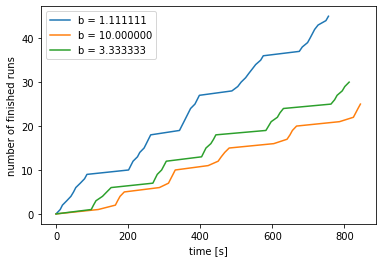

15:30:44 locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x13a40a310>
15:30:44 Using auto colorbar locator on colorbar
15:30:44 locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x13a40a310>
15:30:44 Setting pcolormesh
15:30:44 not adjusting title pos because a title was already placed manually: 1.050000
15:30:45 title position was updated manually, not adjusting
15:30:45 title position was updated manually, not adjusting
15:30:45 title position was updated manually, not adjusting
15:30:45 title position was updated manually, not adjusting
15:30:45 title position was updated manually, not adjusting


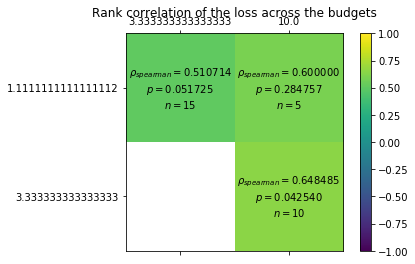

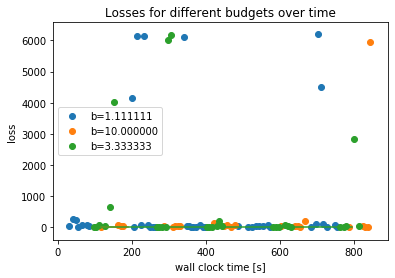

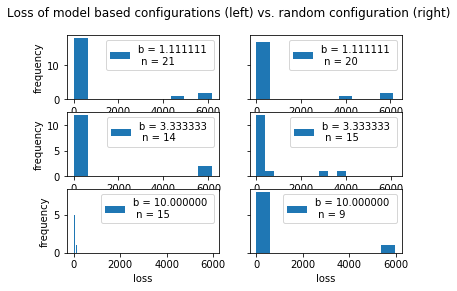

In [14]:
hpvis.finished_runs_over_time(all_runs, show=True)
hpvis.correlation_across_budgets(result, show=True)
hpvis.losses_over_time(all_runs, show=True)
hpvis.performance_histogram_model_vs_random(all_runs, id2config, show=True)
plt.show()